# SENTIMENT ANALYSIS - AMAZON PHONES DATASET

### Library imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
from plotly import subplots
import plotly.offline as py
import plotly.graph_objs as go
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline

sns.set() # use seaborn plotting style


%cd ..
from utils import preprocessing_helpers


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



e:\ELFAK\NLP\Project_Sentiment-Analysis


e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading dataset

In [3]:
dataset = pd.read_csv("./data/Amazon_Unlocked_Mobile.csv", index_col=False)


### Dataset review

In [4]:
dataset.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [5]:
dataset.describe(include='object')

,Product Name,Brand Name,Reviews
count,413840,348669,413770
unique,4410,384,162490
top,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,Samsung,Good
freq,1451,65747,2879


In [6]:
dataset.isna().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            70
Review Votes    12296
dtype: int64

# Dataset preprocessing

### Selecting important features

In [7]:
filtered_dataset = dataset[['Reviews', 'Rating']].copy()
filtered_dataset.head()

,Reviews,Rating
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4


### Encoding rating feature

In [8]:
filtered_dataset['Label'] = filtered_dataset['Rating'].apply(preprocessing_helpers.Encode_rating) 
filtered_dataset.drop('Rating', axis=1, inplace=True)
print("Unique values of Label: ", filtered_dataset['Label'].unique())
filtered_dataset.head()

Unique values of Label:  ['Positive' 'Negative' 'Neutral']


,Reviews,Label
0,I feel so LUCKY to have found this used (phone...,Positive
1,"nice phone, nice up grade from my pantach revu...",Positive
2,Very pleased,Positive
3,It works good but it goes slow sometimes but i...,Positive
4,Great phone to replace my lost phone. The only...,Positive


### Dropping rows with NaN

In [9]:
print("Dataset shape before dropping: ", filtered_dataset.shape)
filtered_dataset.dropna(inplace=True)
print("Dataset shape after dropping: ", filtered_dataset.shape)

Dataset shape before dropping:  (413840, 2)
Dataset shape after dropping:  (413770, 2)


In [10]:
filtered_dataset.describe()

,Reviews,Label
count,413770,413770
unique,162490,3
top,Good,Positive
freq,2879,284948


In [11]:
filtered_dataset.head()

,Reviews,Label
0,I feel so LUCKY to have found this used (phone...,Positive
1,"nice phone, nice up grade from my pantach revu...",Positive
2,Very pleased,Positive
3,It works good but it goes slow sometimes but i...,Positive
4,Great phone to replace my lost phone. The only...,Positive


In [12]:
non_preprocessed_dataset = filtered_dataset.copy()

### Removing URLs from review feature

In [13]:
filtered_dataset['CleanReviews'] = filtered_dataset['Reviews'].apply(preprocessing_helpers.Removing_url)

### Removing characters that are not alphanumeric

In [14]:
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Clean_non_alphanumeric)

### Converting reviews to lower case 

In [15]:
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Convert_to_lowercase)

### Tokenization of review texts

In [16]:
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Tokenize_text)

### Removing rows where review consisted of only stop words

In [17]:
filtered_dataset = filtered_dataset.replace('', pd.NA).dropna()

In [18]:
print(filtered_dataset.shape)
filtered_dataset.head()

(413770, 3)


,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,"[i, feel, so, lucky, to, have, found, this, us..."
1,"nice phone, nice up grade from my pantach revu...",Positive,"[nice, phone, nice, up, grade, from, my, panta..."
2,Very pleased,Positive,"[very, pleased]"
3,It works good but it goes slow sometimes but i...,Positive,"[it, works, good, but, it, goes, slow, sometim..."
4,Great phone to replace my lost phone. The only...,Positive,"[great, phone, to, replace, my, lost, phone, t..."


### Removing english stopwords

In [19]:
print(filtered_dataset.shape)
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Remove_stopwords)

(413770, 3)


### Stemming

In [20]:
#dataset['CleanReviews'] = dataset['CleanReviews'].apply(preprocessing_helpers.Stemming)

### Lemmatization

In [21]:
print(filtered_dataset.shape)
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Lemmatization)

(413770, 3)


In [22]:
filtered_dataset.head(15)

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,"[feel, lucky, find, use, phone, us, use, hard,..."
1,"nice phone, nice up grade from my pantach revu...",Positive,"[nice, phone, nice, grade, pantach, revue, cle..."
2,Very pleased,Positive,[please]
3,It works good but it goes slow sometimes but i...,Positive,"[work, good, go, slow, sometimes, good, phone,..."
4,Great phone to replace my lost phone. The only...,Positive,"[great, phone, replace, lose, phone, thing, vo..."
5,I already had a phone with problems... I know ...,Negative,"[already, phone, problems, know, state, use, d..."
6,The charging port was loose. I got that solder...,Negative,"[charge, port, loose, get, solder, need, new, ..."
7,"Phone looks good but wouldn't stay charged, ha...",Negative,"[phone, look, good, stay, charge, buy, new, ba..."
8,I originally was using the Samsung S2 Galaxy f...,Positive,"[originally, use, samsung, galaxy, sprint, wan..."
9,It's battery life is great. It's very responsi...,Neutral,"[battery, life, great, responsive, touch, issu..."


### Converting list of tokens back to string

In [23]:
print(filtered_dataset.shape)
filtered_dataset['CleanReviews'] = filtered_dataset['CleanReviews'].apply(preprocessing_helpers.Convert_list_of_tokens_to_string)

(413770, 3)


In [24]:
filtered_dataset.head(15)

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
5,I already had a phone with problems... I know ...,Negative,already phone problems know state use dang sta...
6,The charging port was loose. I got that solder...,Negative,charge port loose get solder need new battery ...
7,"Phone looks good but wouldn't stay charged, ha...",Negative,phone look good stay charge buy new battery st...
8,I originally was using the Samsung S2 Galaxy f...,Positive,originally use samsung galaxy sprint want retu...
9,It's battery life is great. It's very responsi...,Neutral,battery life great responsive touch issue some...


### Removing texts with more than 2500 tokens (there are about 800 reviews of this type)

In [25]:
print(filtered_dataset.shape)
filtered_dataset = filtered_dataset[ filtered_dataset['CleanReviews'].str.len() < 2500]
print(filtered_dataset.shape)


(413770, 3)
(412985, 3)


### Splitting data to positive and negative datasets

In [26]:
positive_dataset = filtered_dataset[filtered_dataset['Label'] == 'Positive']
negative_dataset = filtered_dataset[filtered_dataset['Label'] == 'Negative']

In [27]:
print("Len of positive dataset: ", positive_dataset.shape[0])
print("Len of negative dataset: ", negative_dataset.shape[0])

Len of positive dataset:  284370
Len of negative dataset:  96932


In [28]:
negative_dataset.head()

,Reviews,Label,CleanReviews
5,I already had a phone with problems... I know ...,Negative,already phone problems know state use dang sta...
6,The charging port was loose. I got that solder...,Negative,charge port loose get solder need new battery ...
7,"Phone looks good but wouldn't stay charged, ha...",Negative,phone look good stay charge buy new battery st...
13,I'm really disappointed about my phone and ser...,Negative,really disappoint phone service phone go week ...
15,Had this phone before and loved it but was not...,Negative,phone love work get phone one thing sd card sl...


In [29]:
reduced_filtered_dataset = filtered_dataset[:2000]
reduced_filtered_dataset

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
...,...,...,...
2001,I had a great hope for this product.This phone...,Neutral,great hope product phone far better phone rang...
2002,Im absolutely amazed with the sound of the spe...,Positive,im absolutely amaze sound speakers htc jbl spe...
2003,Horribleeee experience with this cell phone......,Negative,horribleeee experience cell phone buy first on...
2004,So far very good!,Positive,far good


In [30]:
finetuning_reduced_filtered_dataset = filtered_dataset[:10000]
finetuning_reduced_filtered_dataset

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
...,...,...,...
10013,It was as expected. Looks like brand new. Exce...,Positive,expect look like brand new excellent condition...
10014,Worked for me on t-mobile. I did have to conta...,Positive,work mobile contact seller get phone work mobi...
10015,It came exactly as it was supposed to and very...,Positive,come exactly suppose quickly happy purchase
10016,Thanks,Positive,thank


# EDA Analysis

### Rating attribute before conversion

<Axes: ylabel='Rating'>

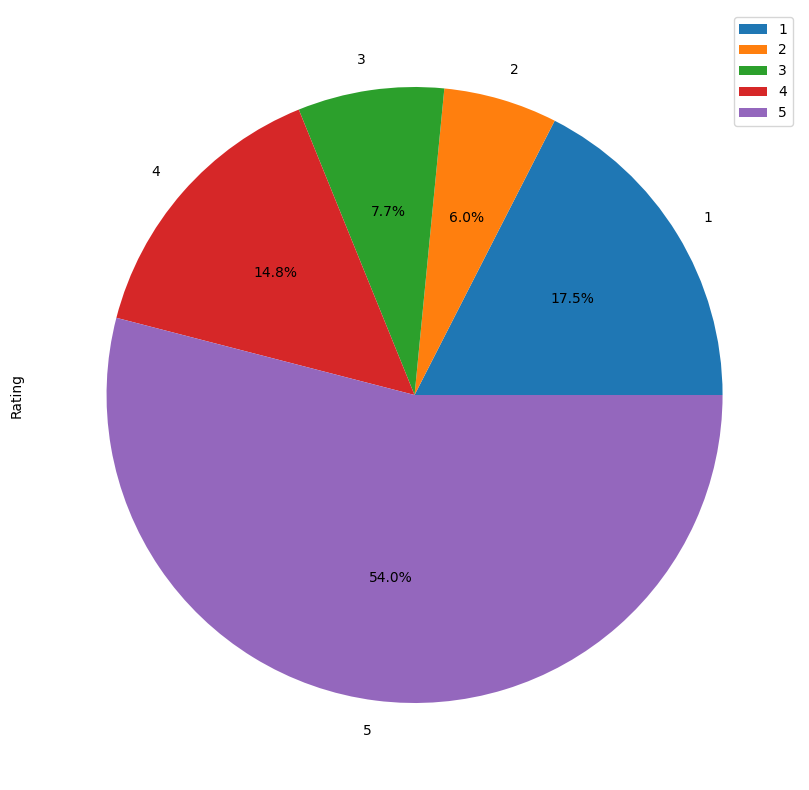

In [30]:
type_counts = dataset['Rating'].value_counts()
df2 = pd.DataFrame({'Rating': type_counts}, 
                     index = [1, 2, 3, 4, 5])
df2.plot.pie(y='Rating', figsize=(10,10), autopct='%1.1f%%')

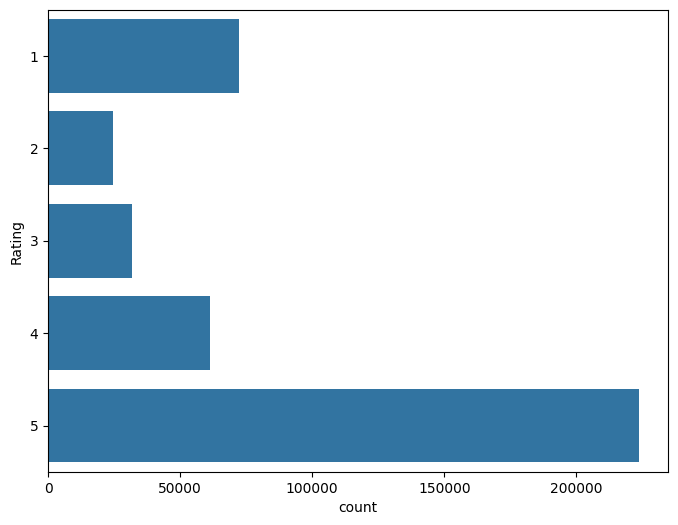

In [31]:
labels = dataset[['Rating']]
plt.figure(figsize=(8,6))
sns.countplot(y='Rating', data=labels)
plt.show()

### Label attribute (Rating attribute after conversion)

<Axes: ylabel='Label'>

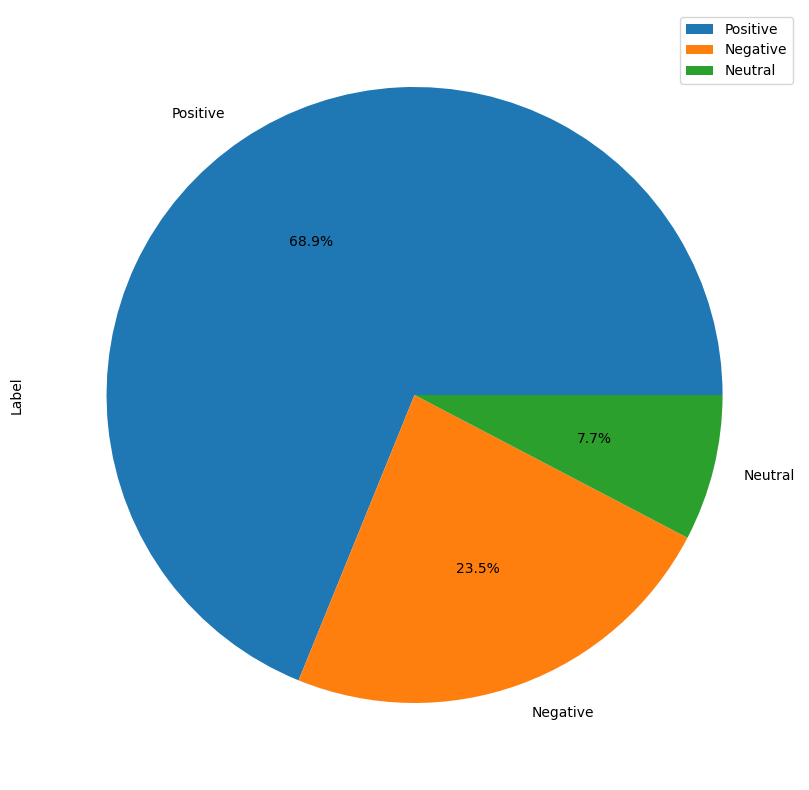

In [32]:
type_counts = filtered_dataset['Label'].value_counts()
df2 = pd.DataFrame({'Label': type_counts}, 
                     index = ['Positive', 'Negative', 'Neutral'])
df2.plot.pie(y='Label', figsize=(10,10), autopct='%1.1f%%')

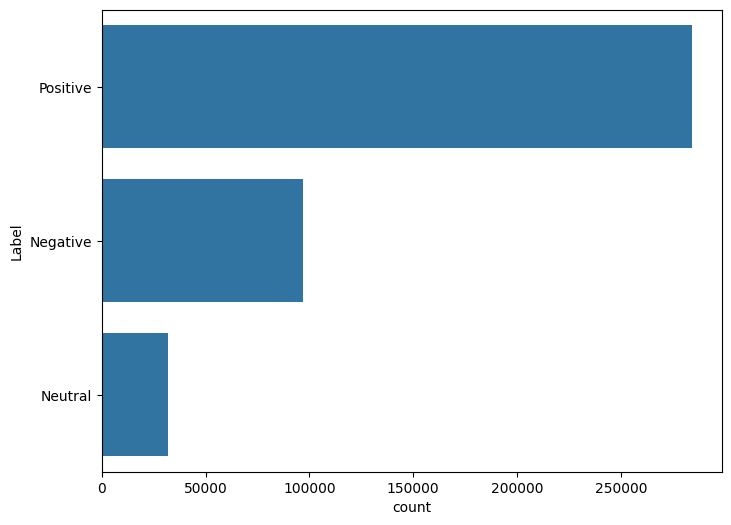

In [33]:
labels = filtered_dataset[['Label']]
plt.figure(figsize=(8,6))
sns.countplot(y='Label', data=labels)
plt.show()

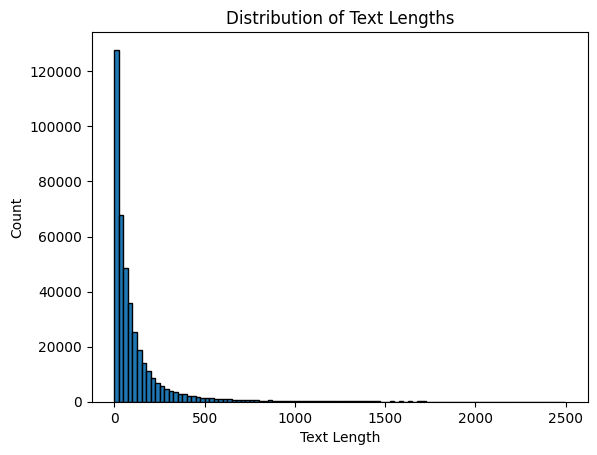

In [51]:
# Calculate the length of each text in 'safe_text'
text_lengths = filtered_dataset['CleanReviews'].apply(len)

# Plot the distribution of text lengths
plt.hist(text_lengths, bins=100, edgecolor='black')
plt.xlabel('Text Length')
#plt.xlim(0, 2500)
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')

plt.show()

### WordCloud

In [53]:

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(16, 8), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', 'phone'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()  
    

#### Positive wordcloud

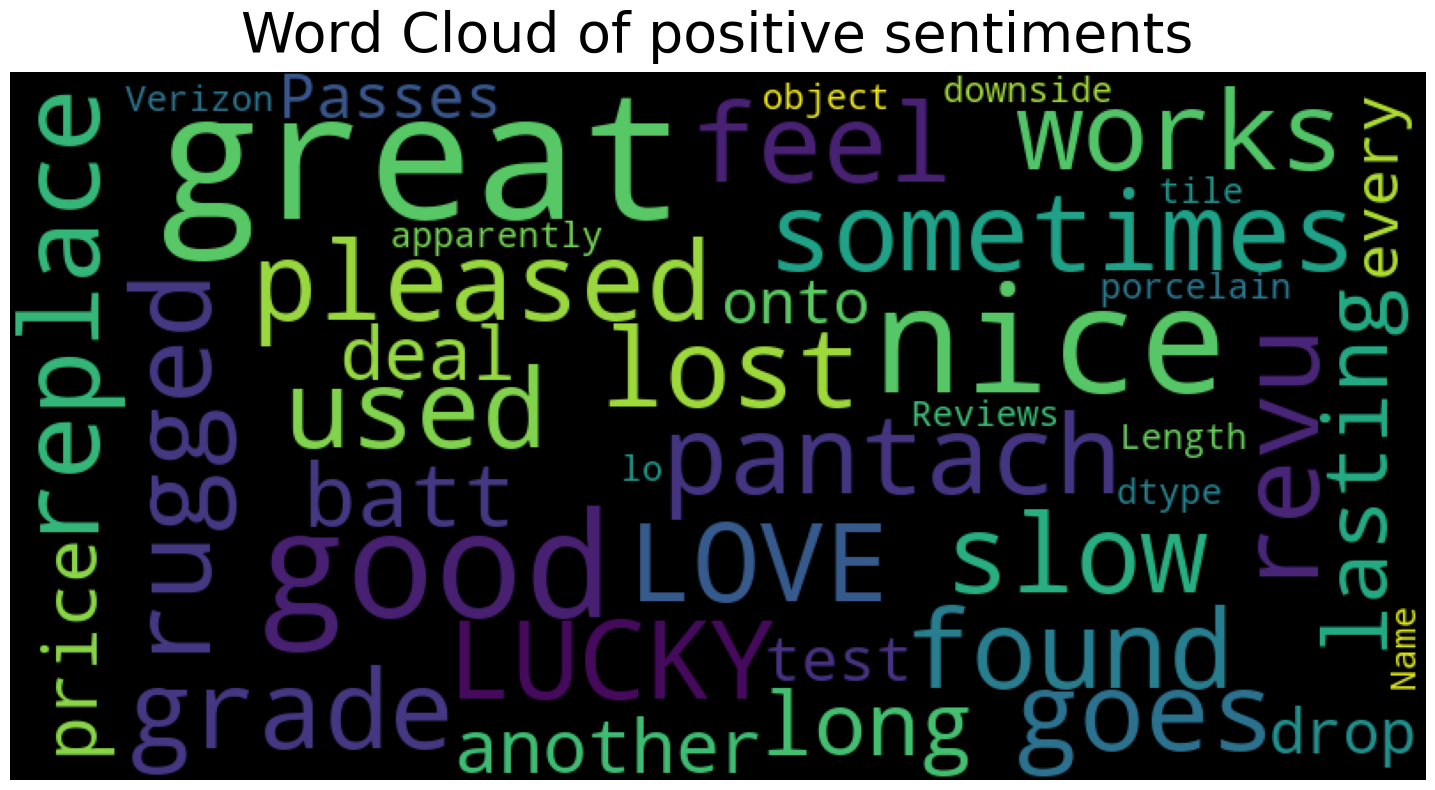

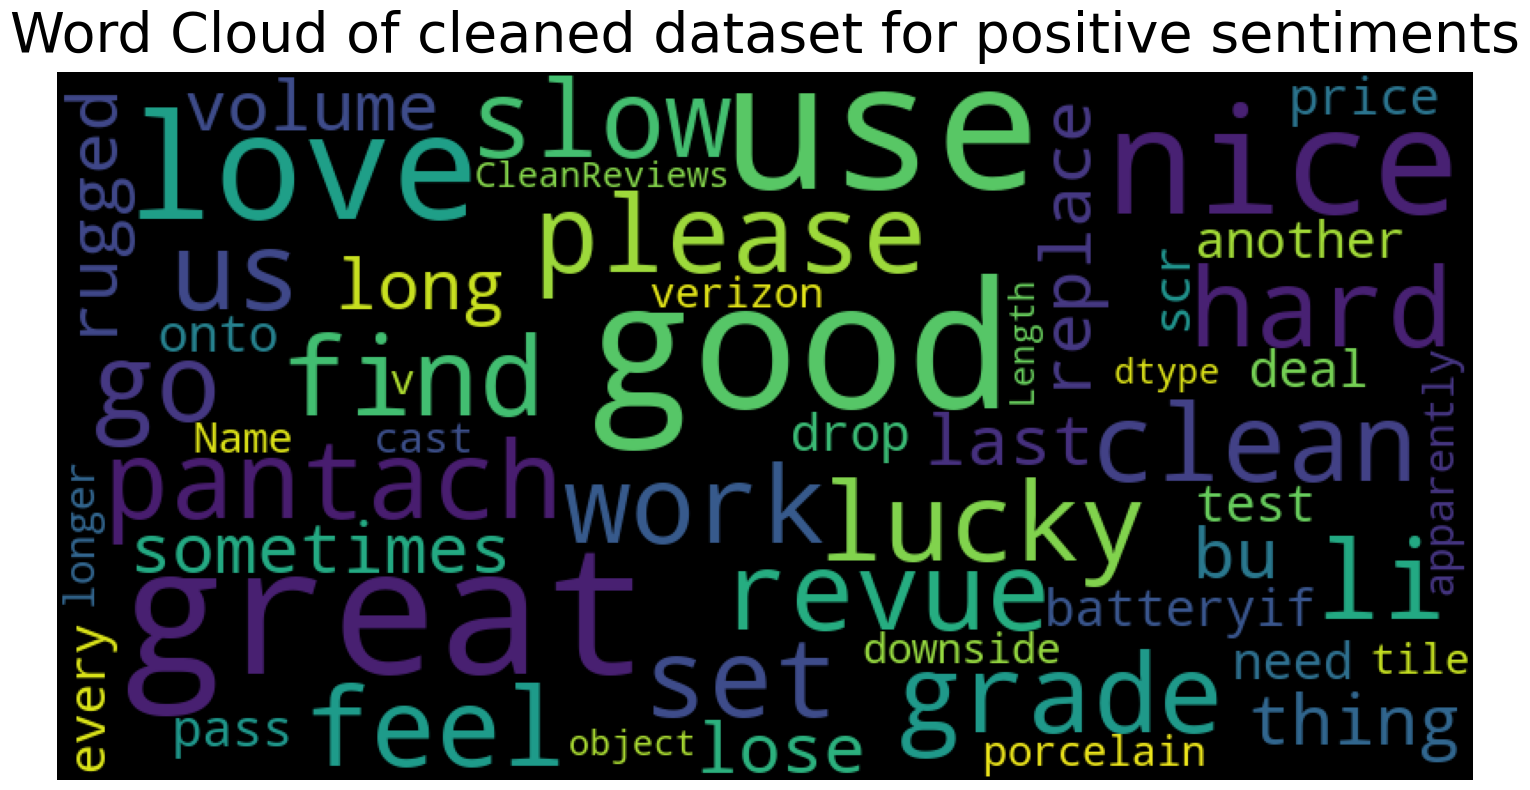

In [54]:
plot_wordcloud(positive_dataset['Reviews'], title="Word Cloud of positive sentiments")
plot_wordcloud(positive_dataset['CleanReviews'], title="Word Cloud of cleaned dataset for positive sentiments")



#### Negative wordcloud

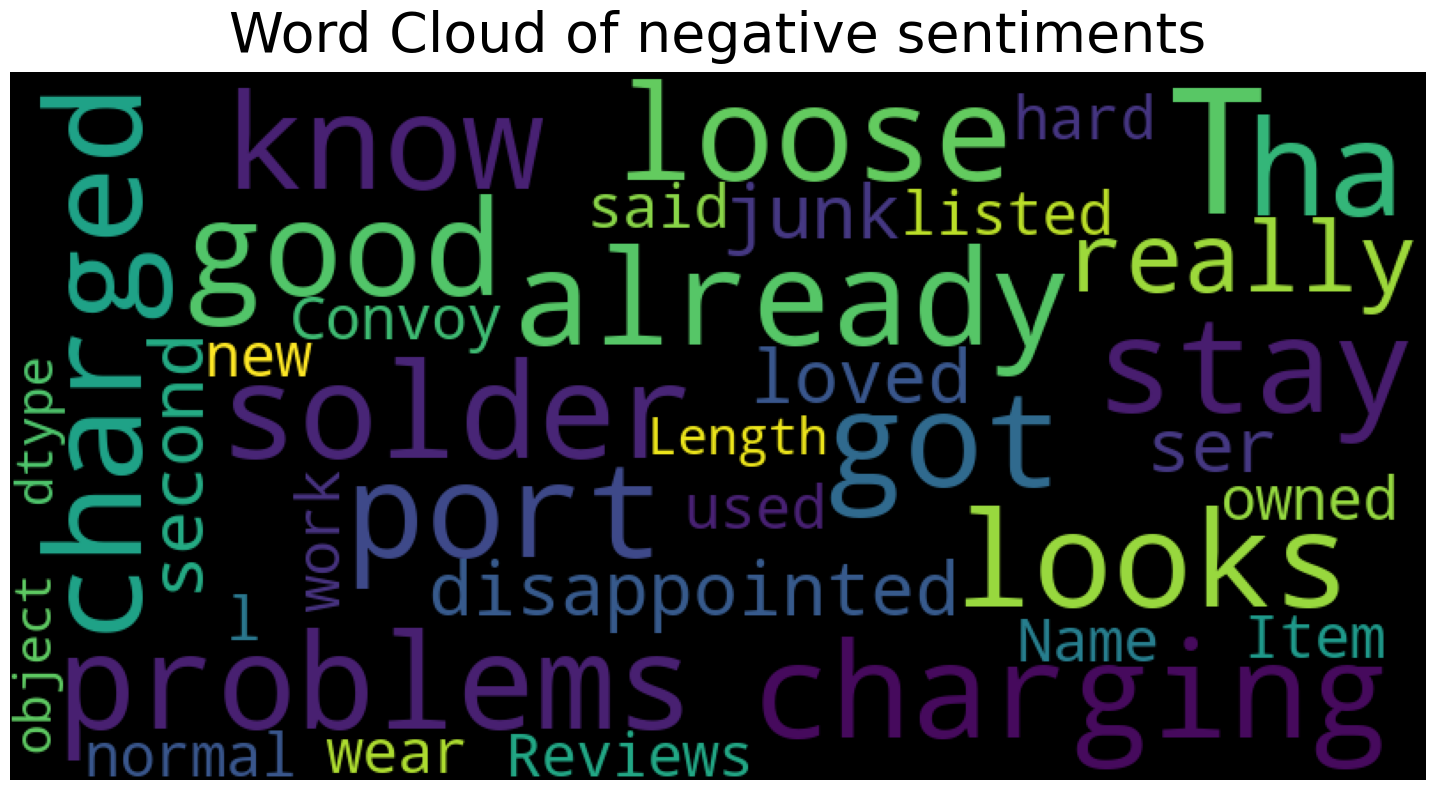

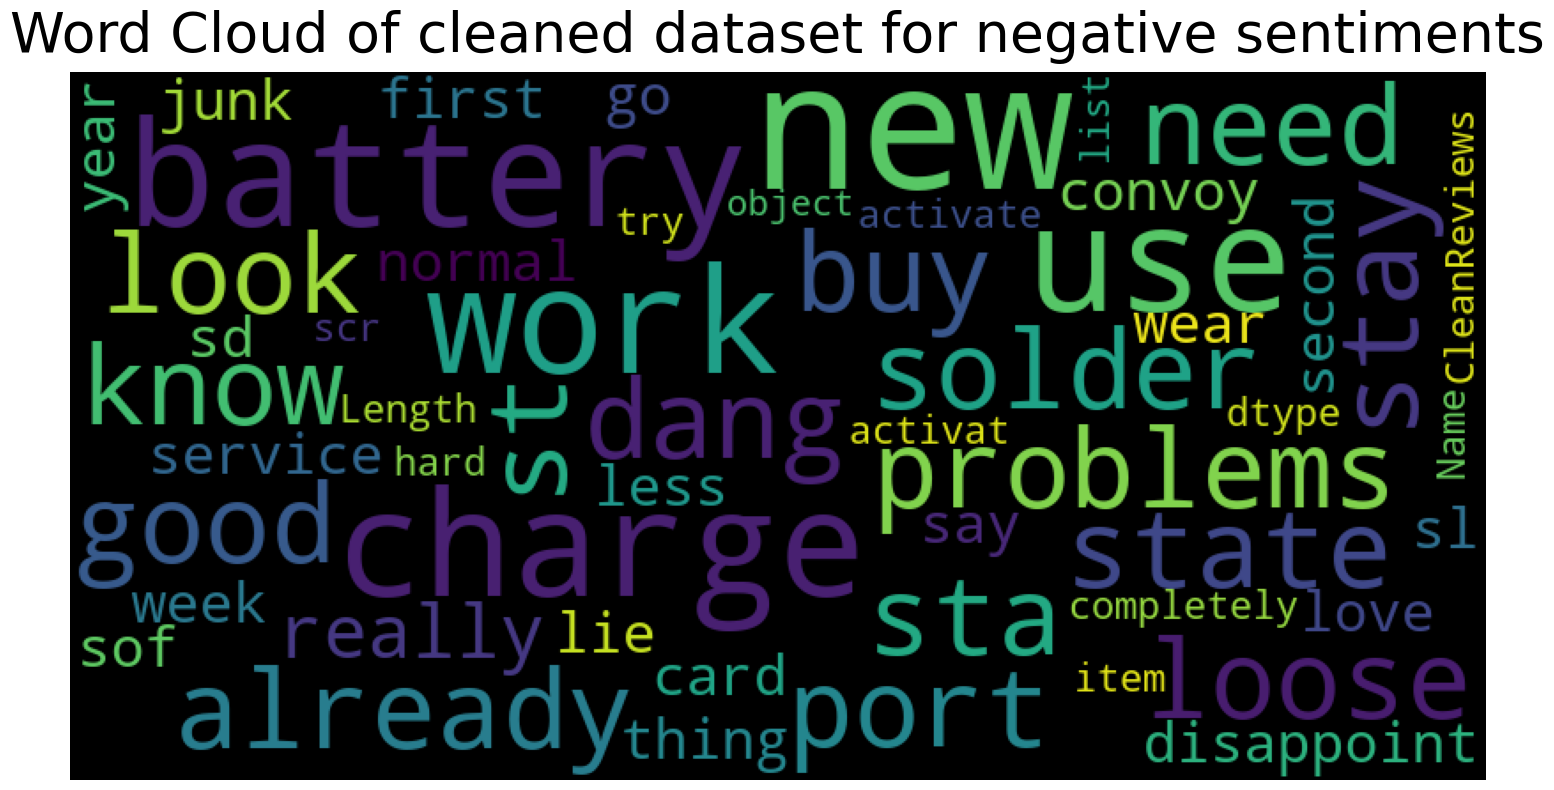

In [11]:
plot_wordcloud(negative_dataset['Reviews'], title="Word Cloud of negative sentiments")
plot_wordcloud(negative_dataset['CleanReviews'], title="Word Cloud of cleaned dataset for negative sentiments")

#### Word count plots

In [59]:

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

common_words = ['phone', 'phone.', 'phone,', 'will', 'one', 'screen', 'battery', 'even', 'use', 'it.']

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in positive_dataset["CleanReviews"]:
    for word in generate_ngrams(sent):
        if word not in common_words:
            freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in negative_dataset["CleanReviews"]:
    for word in generate_ngrams(sent):
        if word not in common_words:
            freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", 
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

### Generating N-grams

#### 2-grams

In [143]:
freq_dict = defaultdict(int)
for sent in positive_dataset["CleanReviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in negative_dataset["CleanReviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of positive reviews", 
                                          "Frequent bigrams of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

#### 3-grams

In [146]:
freq_dict = defaultdict(int)
for sent in positive_dataset["CleanReviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in negative_dataset["CleanReviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of positive reviews", 
                                          "Frequent bigrams of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

#
<div style="background-color:#ffffff;
            letter-spacing:0.5px; text-align: left;">

<h1 style="padding: 5px 0px; color:#028667; font-weight: bold; font-family: Times New Roman">
TRAINING</h1>
</div>

In [34]:
filtered_dataset

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
...,...,...,...
413835,another great deal great price,Positive,another great deal great price
413836,Ok,Neutral,ok
413837,Passes every drop test onto porcelain tile!,Positive,pass every drop test onto porcelain tile
413838,I returned it because it did not meet my needs...,Neutral,return meet need seem good selection others


In [35]:
reduced_filtered_dataset

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
...,...,...,...
2001,I had a great hope for this product.This phone...,Neutral,great hope product phone far better phone rang...
2002,Im absolutely amazed with the sound of the spe...,Positive,im absolutely amaze sound speakers htc jbl spe...
2003,Horribleeee experience with this cell phone......,Negative,horribleeee experience cell phone buy first on...
2004,So far very good!,Positive,far good


In [65]:
finetuning_reduced_filtered_dataset

,Reviews,Label,CleanReviews
0,I feel so LUCKY to have found this used (phone...,Positive,feel lucky find use phone us use hard phone li...
1,"nice phone, nice up grade from my pantach revu...",Positive,nice phone nice grade pantach revue clean set ...
2,Very pleased,Positive,please
3,It works good but it goes slow sometimes but i...,Positive,work good go slow sometimes good phone love
4,Great phone to replace my lost phone. The only...,Positive,great phone replace lose phone thing volume bu...
...,...,...,...
10013,It was as expected. Looks like brand new. Exce...,Positive,expect look like brand new excellent condition...
10014,Worked for me on t-mobile. I did have to conta...,Positive,work mobile contact seller get phone work mobi...
10015,It came exactly as it was supposed to and very...,Positive,come exactly suppose quickly happy purchase
10016,Thanks,Positive,thank


# Bag of Words Transformation vs TF-IDF Transformation

## Includes:
- Bow transformations
- Tf-Idf transformations
- Training Classification algorithms

## Train test split

In [121]:
training_data, test_data = train_test_split(finetuning_reduced_filtered_dataset, train_size = 0.7, random_state=42)
training_data

,Reviews,Label,CleanReviews
9087,Listing said refurbished but you'd never know-...,Positive,list say refurbish never know look like brand ...
2617,The size is perfect for average guy. It's larg...,Positive,size perfect average guy large enough type w t...
7756,Arrived and worked just as expected.,Positive,arrive work expect
1580,I love it excelent service acurate and fast,Positive,love excelent service acurate fast
5075,Works well except for the battery which doesn'...,Neutral,work well except battery hold charge well lose...
...,...,...,...
5751,excelente,Positive,excelente
5208,Good,Positive,good
5407,"This phone is locked, and thats really a bad w...",Negative,phone lock thats really bad way business displ...
860,ok,Positive,ok


In [122]:

def simple_logistic_classify(model, model_name, X_tr, y_tr, X_test, y_test, description):

    model = model.fit(X_tr, y_tr)

    data_table=pd.DataFrame(columns=['model', 'accuracy'])

    # plotting the confusion matrix
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {}".format(accuracy))
    print("Classification report :")
    print(classification_report(y_test, y_pred))

    mat = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print('*' * 50)

    num_rows = data_table.shape[0]
    data_table.loc[num_rows+1] = [model_name, accuracy]

    return data_table


## 1-gram representations

### 1-gram representation of BOW Transformation

In [39]:
bow_vectorizer = CountVectorizer(lowercase=False)

X = bow_vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
pd.DataFrame(X.A, columns=bow_vectorizer.get_feature_names_out())

,acurate,align,allow,around,arrive,average,base,battery,bite,bounce,...,tray,try,type,typically,units,use,user,well,work,yes
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,1,0,1,0,1,...,1,1,1,1,0,1,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,3,1,0,...,0,0,0,0,1,0,0,2,2,1


### 1-gram representation of TfidfTransformer transforming results from BOW Transformation

In [40]:
tfidf_transform = TfidfTransformer(norm=None)
X = tfidf_transform.fit_transform(X)
pd.DataFrame(X.A, columns=bow_vectorizer.get_feature_names_out())

,acurate,align,allow,around,arrive,average,base,battery,bite,bounce,...,tray,try,type,typically,units,use,user,well,work,yes
0,0.000000,0.000000,0.000000,0.000000,1.693147,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.405465,0.000000
1,0.000000,2.098612,2.098612,2.098612,0.000000,2.098612,0.000000,1.693147,0.000000,2.098612,...,2.098612,2.098612,2.098612,2.098612,0.000000,2.098612,2.098612,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,1.693147,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.405465,0.000000
3,2.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098612,5.079442,2.098612,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.098612,0.000000,0.000000,4.197225,2.810930,2.098612


### 1-gram representation of TfIdfVectorizer without IDF

In [41]:
vectorizer = TfidfVectorizer(use_idf=False) 
X = vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
df = pd.DataFrame(np.round(X.A,3), columns=vectorizer.get_feature_names_out())
df

,acurate,align,allow,around,arrive,average,base,battery,bite,bounce,...,tray,try,type,typically,units,use,user,well,work,yes
0,0.000,0.000,0.000,0.000,0.250,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.000
1,0.000,0.108,0.108,0.108,0.000,0.108,0.000,0.108,0.000,0.108,...,0.108,0.108,0.108,0.108,0.000,0.108,0.108,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.577,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.577,0.000
3,0.447,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.141,0.424,0.141,0.000,...,0.000,0.000,0.000,0.000,0.141,0.000,0.000,0.283,0.283,0.141


### 1-gram representation of TfIdfVectorizer with IDF

In [42]:
vectorizer = TfidfVectorizer() 
X = vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
df = pd.DataFrame(np.round(X.A,3), columns=vectorizer.get_feature_names_out())
df

,acurate,align,allow,around,arrive,average,base,battery,bite,bounce,...,tray,try,type,typically,units,use,user,well,work,yes
0,0.000,0.000,0.000,0.000,0.214,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.178,0.000
1,0.000,0.109,0.109,0.109,0.000,0.109,0.000,0.088,0.000,0.109,...,0.109,0.109,0.109,0.109,0.000,0.109,0.109,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.557,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.462,0.000
3,0.447,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.152,0.367,0.152,0.000,...,0.000,0.000,0.000,0.000,0.152,0.000,0.000,0.304,0.203,0.152


## Preparing data

### Preparing data using CountVectorizer

In [132]:
bow_transform = CountVectorizer(lowercase=False) 
X_tr_bow = bow_transform.fit_transform(training_data['CleanReviews'])
y_tr = training_data['Label']

y_bow_transform = CountVectorizer(lowercase=False) 

y_tr_transformed_using_bow = y_bow_transform.fit_transform(training_data['Label'])

print("Shape of X_tr_bow: ", X_tr_bow.shape)
print("Shape of y_tr: ", y_tr.shape)

print("len(bow_transform.vocabulary_): ", len(bow_transform.vocabulary_))

X_te_bow = bow_transform.transform(test_data['CleanReviews'])
y_te = test_data['Label']

y_te_transformed_using_bow = y_bow_transform.transform(test_data['Label'])

print("Shape of X_te_bow: ", X_te_bow.shape)
print("Shape of y_te: ", y_te.shape)

print("Shape of y_tr_transformed_using_bow: ", y_tr_transformed_using_bow.shape)
print("Shape of y_te_transformed_using_bow: ", y_te_transformed_using_bow.shape)


Shape of X_tr_bow:  (7000, 6434)
Shape of y_tr:  (7000,)
len(bow_transform.vocabulary_):  6434
Shape of X_te_bow:  (3000, 6434)
Shape of y_te:  (3000,)
Shape of y_tr_transformed_using_bow:  (7000, 3)
Shape of y_te_transformed_using_bow:  (3000, 3)


### Preparing data using TfidfTransformer

In [133]:

tfidf_transform = TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

y_tfidf_transform = TfidfTransformer(norm=None)

y_tr_transformed_using_TfIdfTransformer = y_tfidf_transform.fit_transform(y_tr_transformed_using_bow)
y_te_transformed_using_TfIdfTransformer = y_tfidf_transform.transform(y_te_transformed_using_bow)

print("Shape of X_tr_tfidf: ", X_tr_tfidf.shape)
print("Shape of X_te_tfidf: ", X_te_tfidf.shape)

print("Shape of y_tr_transformed_using_TfIdfTransformer: ", y_tr_transformed_using_TfIdfTransformer.shape)
print("Shape of y_te_transformed_using_TfIdfTransformer: ", y_te_transformed_using_TfIdfTransformer.shape)



Shape of X_tr_tfidf:  (7000, 6434)
Shape of X_te_tfidf:  (3000, 6434)
Shape of y_tr_transformed_using_TfIdfTransformer:  (7000, 3)
Shape of y_te_transformed_using_TfIdfTransformer:  (3000, 3)


### Preparing data using TfidfVectorizer

In [134]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
X_tfidf_tr = tfidf_vectorizer.fit_transform(training_data['CleanReviews'])
X_tfidf_te = tfidf_vectorizer.transform(test_data['CleanReviews'])

y_tfidf_vectorizer = TfidfVectorizer()
y_tr_transformed_using_TfidfVectorizer = y_tfidf_vectorizer.fit_transform(training_data['Label'])
y_te_transformed_using_TfidfVectorizer = y_tfidf_vectorizer.transform(test_data['Label'])

print("Shape of X_tfidf_tr: ", X_tfidf_tr.shape)
print("Shape of X_tfidf_te: ", X_tfidf_te.shape)

print("Shape of y_tr_transformed_using_TfidfVectorizer: ", y_tr_transformed_using_TfidfVectorizer.shape)
print("Shape of y_te_transformed_using_TfidfVectorizer: ", y_te_transformed_using_TfidfVectorizer.shape)



Shape of X_tfidf_tr:  (7000, 6434)
Shape of X_tfidf_te:  (3000, 6434)
Shape of y_tr_transformed_using_TfidfVectorizer:  (7000, 3)
Shape of y_te_transformed_using_TfidfVectorizer:  (3000, 3)


## Classification algorithms using 1-gram vectorizers

In [135]:
BOW_METHOD_STRING = "bow"
TF_IDF_TRANSFORMER_METHOD_STRING = "tf-idf-transformer"
TF_IDF_VECTORIZER_METHOD_STRING = "tf-idf-vectorizer"

### Logistic Regression

Accuracy: 0.8776666666666667
Classification report :
              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85       852
     Neutral       0.69      0.41      0.51       236
    Positive       0.89      0.95      0.92      1912

    accuracy                           0.88      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.87      0.88      0.87      3000



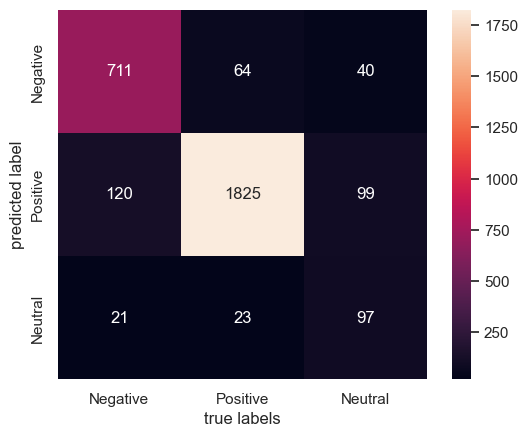

**************************************************
Accuracy: 0.8836666666666667
Classification report :
              precision    recall  f1-score   support

    Negative       0.88      0.84      0.86       852
     Neutral       0.63      0.59      0.61       236
    Positive       0.91      0.94      0.93      1912

    accuracy                           0.88      3000
   macro avg       0.81      0.79      0.80      3000
weighted avg       0.88      0.88      0.88      3000



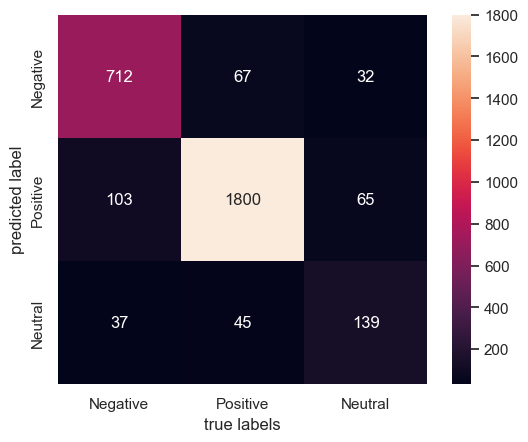

**************************************************
Accuracy: 0.8543333333333333
Classification report :
              precision    recall  f1-score   support

    Negative       0.84      0.81      0.83       852
     Neutral       0.76      0.12      0.21       236
    Positive       0.86      0.96      0.91      1912

    accuracy                           0.85      3000
   macro avg       0.82      0.63      0.65      3000
weighted avg       0.85      0.85      0.83      3000



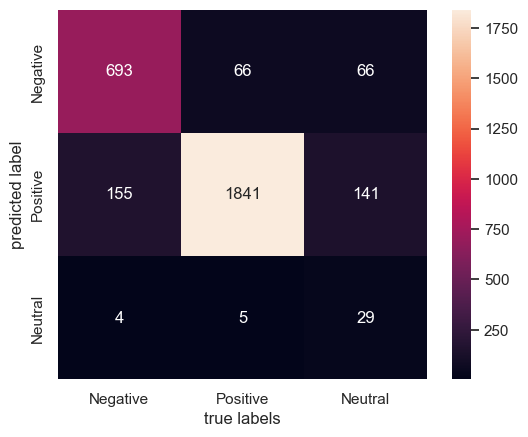

**************************************************


,model,accuracy
0,LogisticRegression_1_gram_bow,0.877667
1,LogisticRegression_1_gram_tf-idf-transformer,0.883667
2,LogisticRegression_1_gram_tf-idf-vectorizer,0.854333


In [136]:
model_name = "LogisticRegression_1_gram"
model = LogisticRegression(max_iter=500) # C=1.0, random_state=0, max_iter=1000)

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_logistic_regression_1_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)
data_table_logistic_regression_1_gram

### Multinomial Naive Bayes

Accuracy: 0.8443333333333334
Classification report :
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81       852
     Neutral       0.60      0.14      0.23       236
    Positive       0.86      0.95      0.90      1912

    accuracy                           0.84      3000
   macro avg       0.76      0.63      0.65      3000
weighted avg       0.83      0.84      0.82      3000



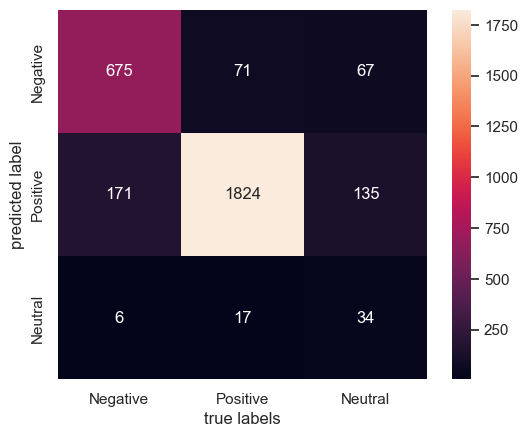

**************************************************


Accuracy: 0.827
Classification report :
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80       852
     Neutral       0.41      0.51      0.46       236
    Positive       0.90      0.88      0.89      1912

    accuracy                           0.83      3000
   macro avg       0.71      0.73      0.71      3000
weighted avg       0.84      0.83      0.83      3000



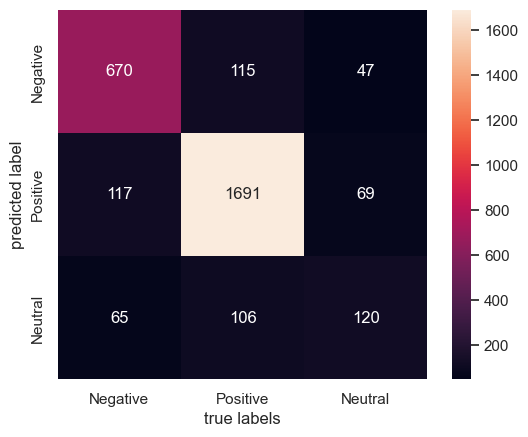

**************************************************
Accuracy: 0.7993333333333333
Classification report :
              precision    recall  f1-score   support

    Negative       0.91      0.59      0.71       852
     Neutral       0.00      0.00      0.00       236
    Positive       0.77      0.99      0.87      1912

    accuracy                           0.80      3000
   macro avg       0.56      0.53      0.53      3000
weighted avg       0.75      0.80      0.76      3000



e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



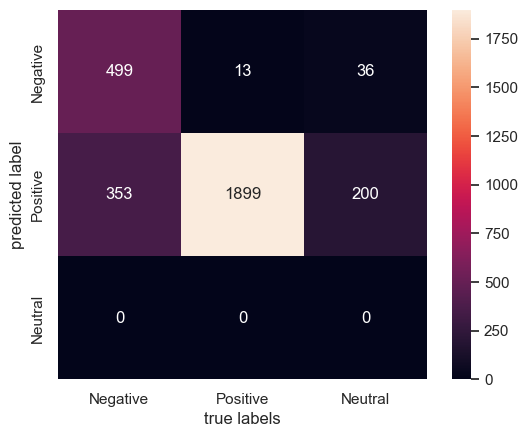

**************************************************


In [137]:
model = MultinomialNB()
model_name = "MultinomialNB_1_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_naive_bayes_1_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)


### XGBoost


Accuracy: 0.87
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       852
           1       0.82      0.32      0.46       236
           2       0.87      0.96      0.92      1912

    accuracy                           0.87      3000
   macro avg       0.85      0.70      0.74      3000
weighted avg       0.87      0.87      0.86      3000



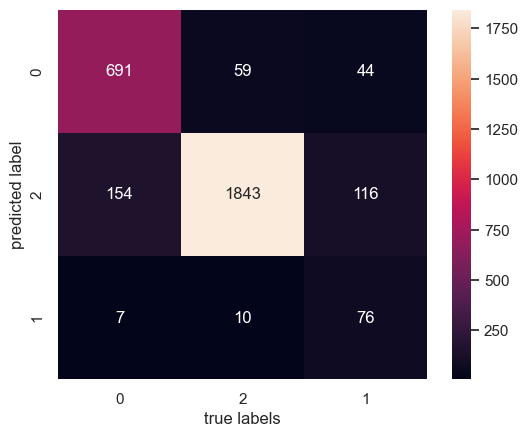

**************************************************
Accuracy: 0.87
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       852
           1       0.82      0.32      0.46       236
           2       0.87      0.96      0.92      1912

    accuracy                           0.87      3000
   macro avg       0.85      0.70      0.74      3000
weighted avg       0.87      0.87      0.86      3000



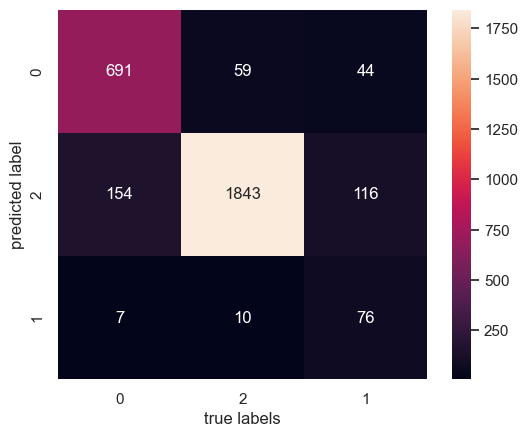

**************************************************
Accuracy: 0.8793333333333333
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       852
           1       0.85      0.38      0.53       236
           2       0.89      0.96      0.92      1912

    accuracy                           0.88      3000
   macro avg       0.87      0.72      0.77      3000
weighted avg       0.88      0.88      0.87      3000



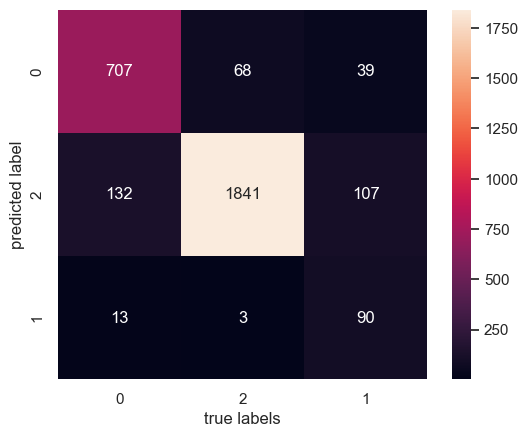

**************************************************


In [138]:

model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
model_name = "XGBClassifier_1_gram"


label_encoder = LabelEncoder()
y_tr_encoded = pd.Series(label_encoder.fit_transform(y_tr))
y_te_encoded = pd.Series(label_encoder.transform(y_te))

# model_bow = simple_logistic_classify(model, X_tr_bow, y_tr_encoded, X_te_bow, y_te_encoded, 'bow')
# model_tfidf = simple_logistic_classify(model, X_tr_tfidf, y_tr_encoded, X_te_tfidf, y_te_encoded, 'tf-idf-transformer')
# model_tfidf = simple_logistic_classify(model, X_tfidf_tr, y_tr_encoded, X_tfidf_te, y_te_encoded, 'tf-idf-vectorizer')

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr_encoded, X_te_bow, y_te_encoded, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr_encoded, X_te_tfidf, y_te_encoded, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr_encoded, X_tfidf_te, y_te_encoded, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_xgb_1_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)



### Support Vector Machine (SVM)

Accuracy: 0.875
Classification report :
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.85       852
     Neutral       0.63      0.47      0.54       236
    Positive       0.90      0.94      0.92      1912

    accuracy                           0.88      3000
   macro avg       0.80      0.75      0.77      3000
weighted avg       0.87      0.88      0.87      3000



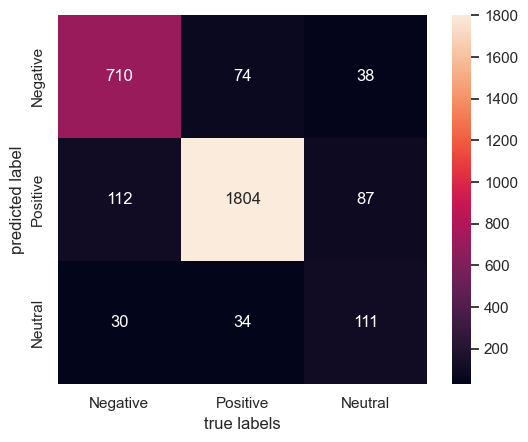

**************************************************
Accuracy: 0.8666666666666667
Classification report :
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83       852
     Neutral       0.59      0.58      0.58       236
    Positive       0.92      0.92      0.92      1912

    accuracy                           0.87      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.87      0.87      0.87      3000



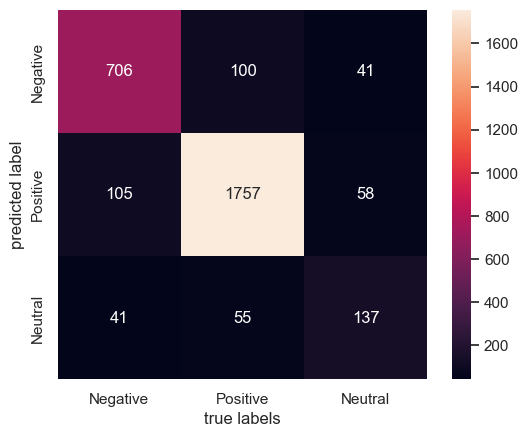

**************************************************
Accuracy: 0.874
Classification report :
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85       852
     Neutral       0.77      0.24      0.37       236
    Positive       0.88      0.96      0.92      1912

    accuracy                           0.87      3000
   macro avg       0.84      0.69      0.71      3000
weighted avg       0.87      0.87      0.86      3000



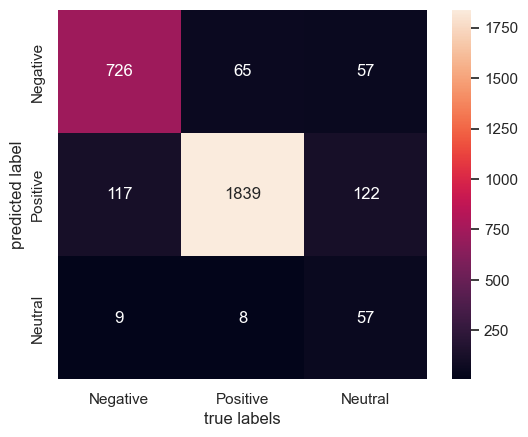

**************************************************


In [139]:
model = SVC(kernel='linear')
model_name = "SVC_1_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_svc_1_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)

### Random Forest

Accuracy: 0.8986666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.89      0.86      0.88       852
     Neutral       0.96      0.47      0.63       236
    Positive       0.90      0.97      0.93      1912

    accuracy                           0.90      3000
   macro avg       0.92      0.77      0.81      3000
weighted avg       0.90      0.90      0.89      3000



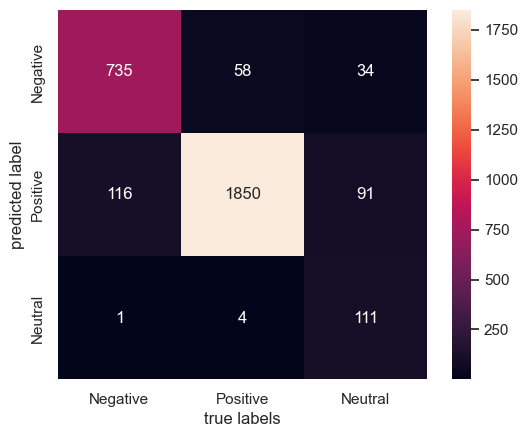

**************************************************
Accuracy: 0.8986666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.89      0.86      0.88       852
     Neutral       0.96      0.47      0.63       236
    Positive       0.90      0.97      0.93      1912

    accuracy                           0.90      3000
   macro avg       0.92      0.77      0.81      3000
weighted avg       0.90      0.90      0.89      3000



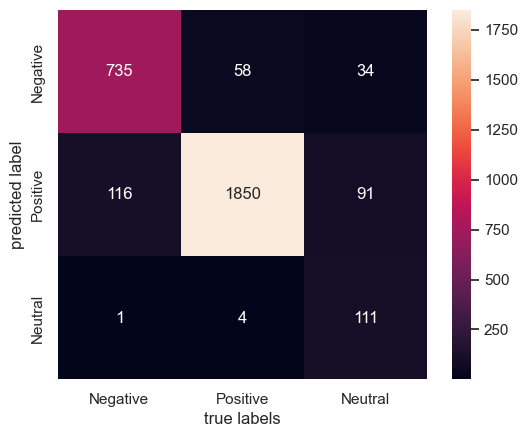

**************************************************
Accuracy: 0.8993333333333333
Classification report :
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87       852
     Neutral       0.97      0.47      0.63       236
    Positive       0.90      0.98      0.93      1912

    accuracy                           0.90      3000
   macro avg       0.92      0.76      0.81      3000
weighted avg       0.90      0.90      0.89      3000



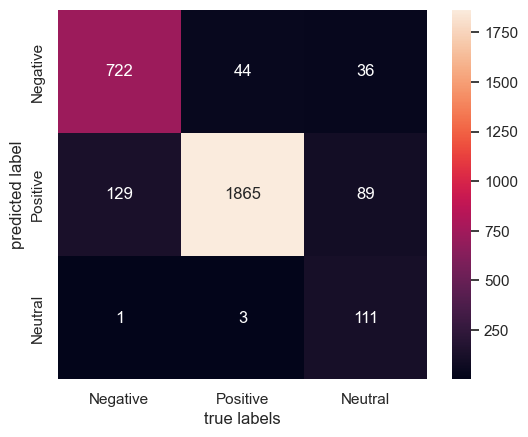

**************************************************


In [140]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model_name = "RandomForestClassifier_1_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_rfc_1_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)

### Getting all results together

In [141]:
data_table_1_gram = pd.concat([data_table_logistic_regression_1_gram, data_table_naive_bayes_1_gram, data_table_xgb_1_gram, data_table_svc_1_gram, data_table_rfc_1_gram], ignore_index=True)

## 3-gram representations

### 3-gram representation of BOW Transformation

In [75]:

# bow_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(3,3), lowercase=False) #, stop_words='english') 

bow_vectorizer = CountVectorizer(tokenizer=lambda doc: doc.split(), ngram_range=(3,3), lowercase=False)
X = bow_vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
pd.DataFrame(X.A, columns=bow_vectorizer.get_feature_names_out())

e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



,allow secure fit,around pant pocket,arrive work expect,average guy large,base shaky battery,battery hold charge,battery life good,battery life power,battery regularly doesnt,bounce around pant,...,use w one,user cell data,w one hand,w thumb small,well except battery,well lose power,work great arrive,work much longer,work well except,yes calibrate battery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,1,0,0,1,0,0,1,...,1,1,1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,1,1,0,1,1,1


### 3-gram representation of TfidfTransformer using result from BOW Transformation

In [76]:
tfidf_transform = TfidfTransformer(norm=None)
X = tfidf_transform.fit_transform(X)
pd.DataFrame(X.A, columns=bow_vectorizer.get_feature_names_out())

,allow secure fit,around pant pocket,arrive work expect,average guy large,base shaky battery,battery hold charge,battery life good,battery life power,battery regularly doesnt,bounce around pant,...,use w one,user cell data,w one hand,w thumb small,well except battery,well lose power,work great arrive,work much longer,work well except,yes calibrate battery
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098612,0.000000,0.000000,0.000000
1,2.098612,2.098612,0.000000,2.098612,0.000000,0.000000,2.098612,0.000000,0.000000,2.098612,...,2.098612,2.098612,2.098612,2.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,2.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,2.098612,2.098612,0.000000,2.098612,2.098612,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.098612,2.098612,0.000000,2.098612,2.098612,2.098612


### 3-gram representation of TfIdfVectorizer without IDF

In [77]:
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=lambda doc: doc.split(), ngram_range=(3,3)) 
X = vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
df = pd.DataFrame(np.round(X.A,3), columns=vectorizer.get_feature_names_out())
df

e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



,allow secure fit,around pant pocket,arrive work expect,average guy large,base shaky battery,battery hold charge,battery life good,battery life power,battery regularly doesnt,bounce around pant,...,use w one,user cell data,w one hand,w thumb small,well except battery,well lose power,work great arrive,work much longer,work well except,yes calibrate battery
0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.267,0.000,0.000,0.000
1,0.124,0.124,0.0,0.124,0.000,0.000,0.124,0.000,0.000,0.124,...,0.124,0.124,0.124,0.124,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.0,0.000,0.171,0.171,0.000,0.171,0.171,0.000,...,0.000,0.000,0.000,0.000,0.171,0.171,0.000,0.171,0.171,0.171


### 3-gram representation of TfIdfVectorizer with IDF

In [78]:
vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda doc: doc.split(), ngram_range=(3,3)) 
X = vectorizer.fit_transform(training_data['CleanReviews'][:5]) 
df = pd.DataFrame(np.round(X.A,3), columns=vectorizer.get_feature_names_out())
df

e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



,allow secure fit,around pant pocket,arrive work expect,average guy large,base shaky battery,battery hold charge,battery life good,battery life power,battery regularly doesnt,bounce around pant,...,use w one,user cell data,w one hand,w thumb small,well except battery,well lose power,work great arrive,work much longer,work well except,yes calibrate battery
0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.267,0.000,0.000,0.000
1,0.124,0.124,0.0,0.124,0.000,0.000,0.124,0.000,0.000,0.124,...,0.124,0.124,0.124,0.124,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.0,0.000,0.171,0.171,0.000,0.171,0.171,0.000,...,0.000,0.000,0.000,0.000,0.171,0.171,0.000,0.171,0.171,0.171


## Preparing data

### Preparing data using CountVectorizer

In [142]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc.split(), ngram_range=(3,3), lowercase=False) #, stop_words='english') 
X_tr_bow = bow_transform.fit_transform(training_data['CleanReviews'])
y_tr = training_data['Label']

print("Shape of X_tr_bow: ", X_tr_bow.shape)
print("Shape of y_tr: ", y_tr.shape)

print("len(bow_transform.vocabulary_): ", len(bow_transform.vocabulary_))

X_te_bow = bow_transform.transform(test_data['CleanReviews'])
y_te = test_data['Label']

print("Shape of X_te_bow: ", X_te_bow.shape)
print("Shape of y_te: ", y_te.shape)


e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Shape of X_tr_bow:  (7000, 90491)
Shape of y_tr:  (7000,)
len(bow_transform.vocabulary_):  90491
Shape of X_te_bow:  (3000, 90491)
Shape of y_te:  (3000,)


### Preparing data using TfidfTransformer

In [143]:

tfidf_transform = TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

print("Shape of X_tr_tfidf: ", X_tr_tfidf.shape)
print("Shape of X_te_tfidf: ", X_te_tfidf.shape)


Shape of X_tr_tfidf:  (7000, 90491)
Shape of X_te_tfidf:  (3000, 90491)


### Preparing data using TfidfVectorizer

In [144]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda doc: doc.split(), ngram_range=(3,3))

# Fit and transform the text data
X_tfidf_tr = tfidf_vectorizer.fit_transform(training_data['CleanReviews'])
X_tfidf_te = tfidf_vectorizer.transform(test_data['CleanReviews'])

print("Shape of X_tfidf_tr: ", X_tfidf_tr.shape)
print("Shape of X_tfidf_te: ", X_tfidf_te.shape)




Shape of X_tfidf_tr:  (7000, 90491)
Shape of X_tfidf_te:  (3000, 90491)


## Classification algorithms using 3-gram vectorizers

### Logistic Regression

Accuracy: 0.7923333333333333
Classification report :
              precision    recall  f1-score   support

    Negative       0.99      0.44      0.61       852
     Neutral       0.99      0.40      0.57       236
    Positive       0.76      1.00      0.86      1912

    accuracy                           0.79      3000
   macro avg       0.91      0.61      0.68      3000
weighted avg       0.84      0.79      0.77      3000



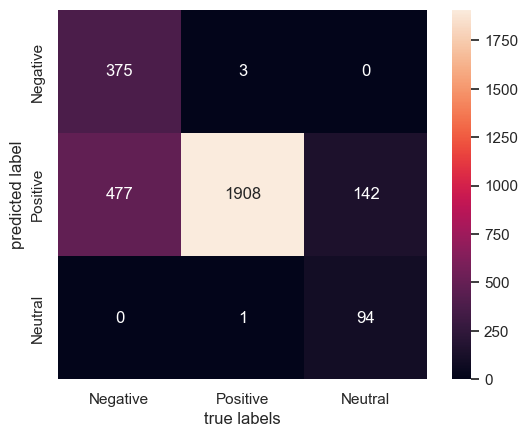

**************************************************


Accuracy: 0.802
Classification report :
              precision    recall  f1-score   support

    Negative       0.98      0.47      0.63       852
     Neutral       0.96      0.44      0.60       236
    Positive       0.77      0.99      0.87      1912

    accuracy                           0.80      3000
   macro avg       0.90      0.64      0.70      3000
weighted avg       0.84      0.80      0.78      3000



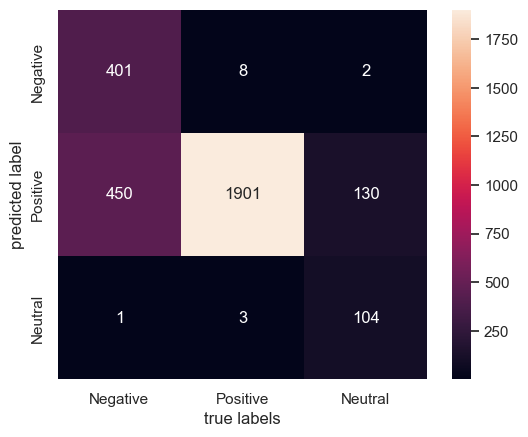

**************************************************
Accuracy: 0.758
Classification report :
              precision    recall  f1-score   support

    Negative       1.00      0.42      0.59       852
     Neutral       1.00      0.02      0.04       236
    Positive       0.72      1.00      0.84      1912

    accuracy                           0.76      3000
   macro avg       0.91      0.48      0.49      3000
weighted avg       0.82      0.76      0.71      3000



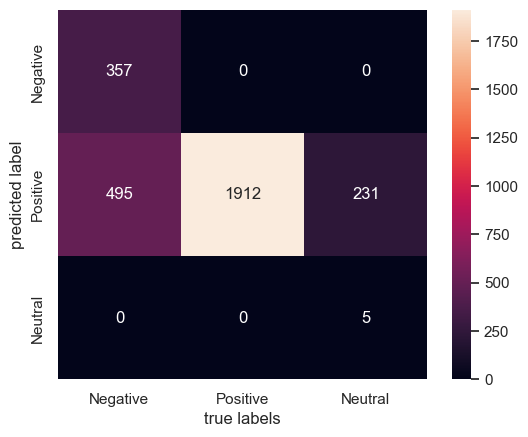

**************************************************


In [145]:
model_name = "LogisticRegression_3_gram"
model = LogisticRegression(max_iter=500) # C=1.0, random_state=0, max_iter=1000)

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_logistic_regression_3_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)

### Multinomial Naive Bayes

Accuracy: 0.8266666666666667
Classification report :
              precision    recall  f1-score   support

    Negative       0.90      0.60      0.72       852
     Neutral       0.90      0.42      0.58       236
    Positive       0.80      0.98      0.88      1912

    accuracy                           0.83      3000
   macro avg       0.87      0.67      0.73      3000
weighted avg       0.84      0.83      0.81      3000



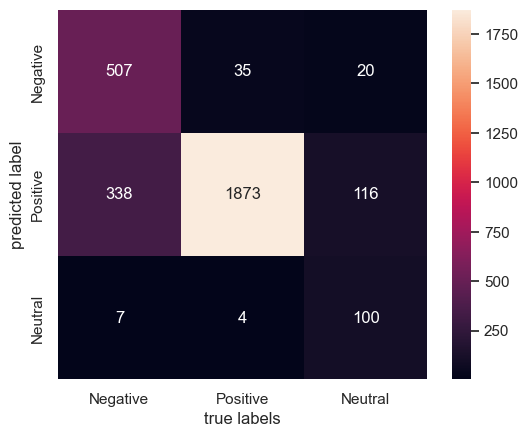

**************************************************
Accuracy: 0.809
Classification report :
              precision    recall  f1-score   support

    Negative       0.86      0.61      0.71       852
     Neutral       0.59      0.51      0.54       236
    Positive       0.82      0.94      0.87      1912

    accuracy                           0.81      3000
   macro avg       0.75      0.68      0.71      3000
weighted avg       0.81      0.81      0.80      3000



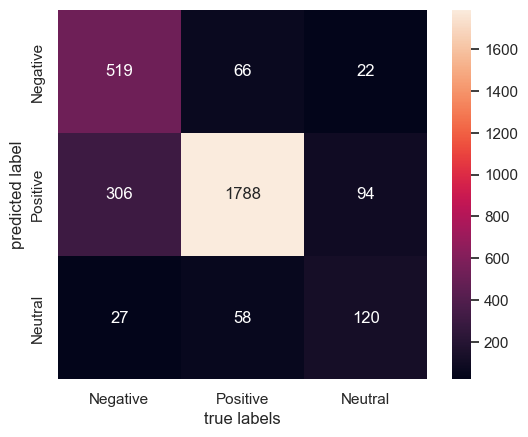

**************************************************
Accuracy: 0.7616666666666667
Classification report :
              precision    recall  f1-score   support

    Negative       1.00      0.42      0.59       852
     Neutral       1.00      0.06      0.11       236
    Positive       0.73      1.00      0.84      1912

    accuracy                           0.76      3000
   macro avg       0.91      0.49      0.52      3000
weighted avg       0.83      0.76      0.71      3000



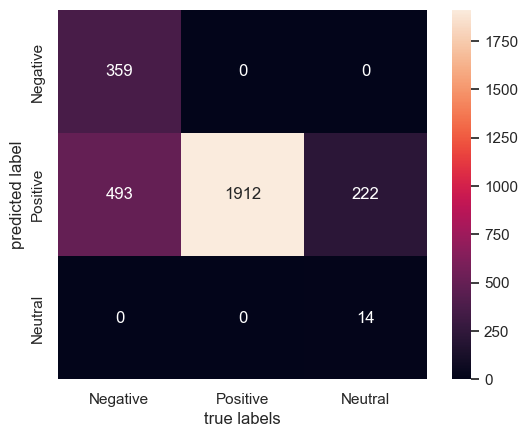

**************************************************


In [146]:
model = MultinomialNB()
model_name = "MultinomialNB_3_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_naive_bayes_3_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)


### XGBoost


Accuracy: 0.6853333333333333
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.17      0.29       852
           1       0.73      0.05      0.09       236
           2       0.67      0.99      0.80      1912

    accuracy                           0.69      3000
   macro avg       0.76      0.40      0.39      3000
weighted avg       0.73      0.69      0.60      3000



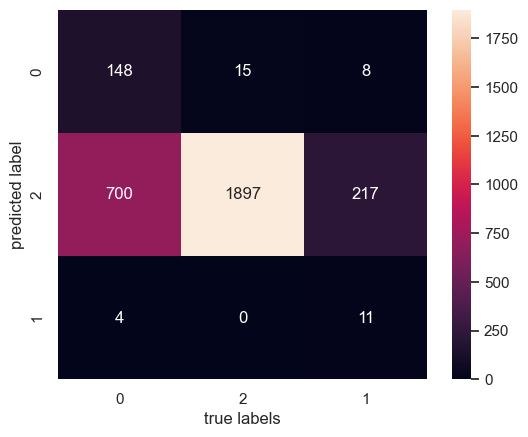

**************************************************
Accuracy: 0.6853333333333333
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.17      0.29       852
           1       0.73      0.05      0.09       236
           2       0.67      0.99      0.80      1912

    accuracy                           0.69      3000
   macro avg       0.76      0.40      0.39      3000
weighted avg       0.73      0.69      0.60      3000



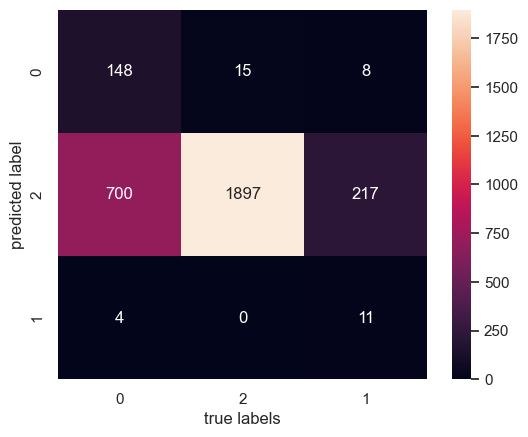

**************************************************
Accuracy: 0.6836666666666666
Classification report :
              precision    recall  f1-score   support

           0       0.84      0.17      0.28       852
           1       0.89      0.07      0.13       236
           2       0.67      0.99      0.80      1912

    accuracy                           0.68      3000
   macro avg       0.80      0.41      0.40      3000
weighted avg       0.74      0.68      0.60      3000



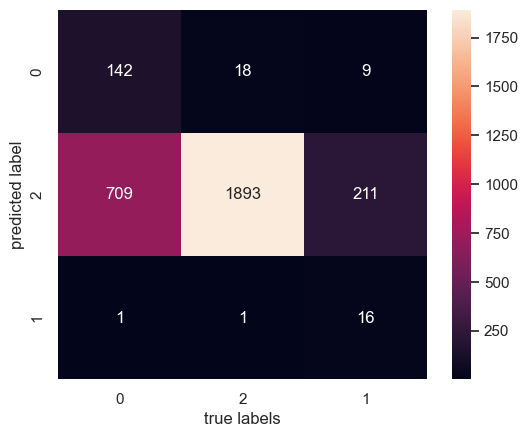

**************************************************


In [147]:
model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
model_name = "XGBClassifier_3_gram"


label_encoder = LabelEncoder()
y_tr_encoded = pd.Series(label_encoder.fit_transform(y_tr))
y_te_encoded = pd.Series(label_encoder.transform(y_te))

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr_encoded, X_te_bow, y_te_encoded, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr_encoded, X_te_tfidf, y_te_encoded, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr_encoded, X_tfidf_te, y_te_encoded, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_xgb_3_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)

### Support Vector Machine (SVM)

Accuracy: 0.7916666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.98      0.44      0.60       852
     Neutral       0.99      0.42      0.59       236
    Positive       0.76      1.00      0.86      1912

    accuracy                           0.79      3000
   macro avg       0.91      0.62      0.69      3000
weighted avg       0.84      0.79      0.77      3000



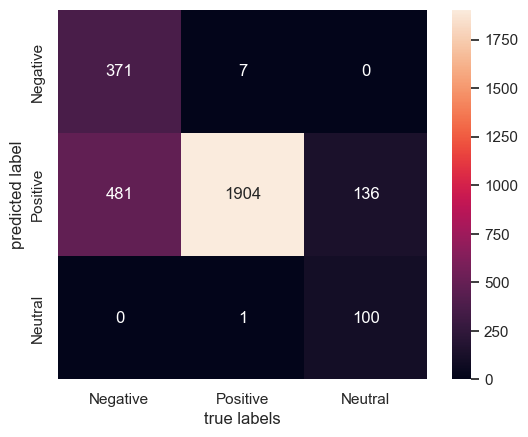

**************************************************
Accuracy: 0.7936666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.99      0.44      0.61       852
     Neutral       0.98      0.44      0.60       236
    Positive       0.76      1.00      0.86      1912

    accuracy                           0.79      3000
   macro avg       0.91      0.62      0.69      3000
weighted avg       0.84      0.79      0.77      3000



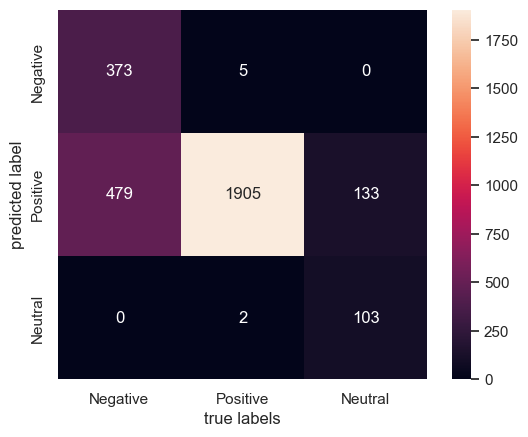

**************************************************
Accuracy: 0.786
Classification report :
              precision    recall  f1-score   support

    Negative       0.98      0.48      0.65       852
     Neutral       0.88      0.18      0.30       236
    Positive       0.75      1.00      0.86      1912

    accuracy                           0.79      3000
   macro avg       0.87      0.55      0.60      3000
weighted avg       0.83      0.79      0.75      3000



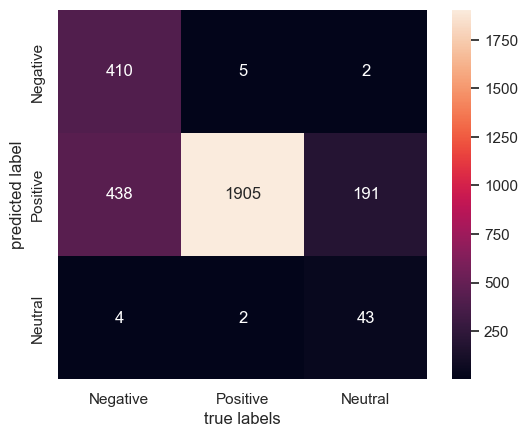

**************************************************


In [148]:
model = SVC(kernel='linear')

model_name = "SVC_3_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_svc_3_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)


### Random Forest

Accuracy: 0.8056666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.98      0.48      0.65       852
     Neutral       0.98      0.44      0.60       236
    Positive       0.77      0.99      0.87      1912

    accuracy                           0.81      3000
   macro avg       0.91      0.64      0.71      3000
weighted avg       0.85      0.81      0.78      3000



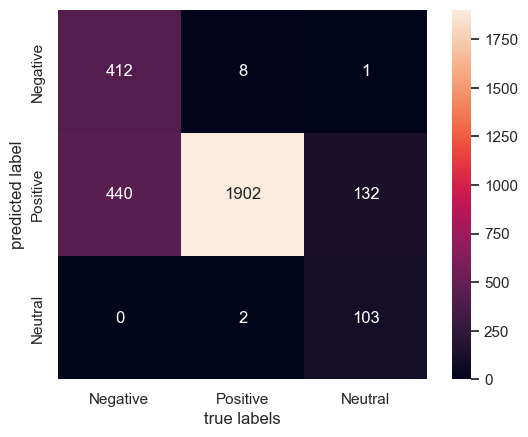

**************************************************
Accuracy: 0.8056666666666666
Classification report :
              precision    recall  f1-score   support

    Negative       0.98      0.48      0.65       852
     Neutral       0.98      0.44      0.60       236
    Positive       0.77      0.99      0.87      1912

    accuracy                           0.81      3000
   macro avg       0.91      0.64      0.71      3000
weighted avg       0.85      0.81      0.78      3000



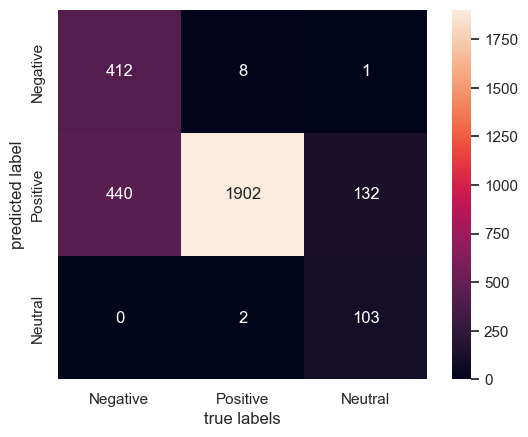

**************************************************
Accuracy: 0.805
Classification report :
              precision    recall  f1-score   support

    Negative       0.96      0.49      0.65       852
     Neutral       0.97      0.43      0.60       236
    Positive       0.77      0.99      0.87      1912

    accuracy                           0.81      3000
   macro avg       0.90      0.64      0.70      3000
weighted avg       0.84      0.81      0.78      3000



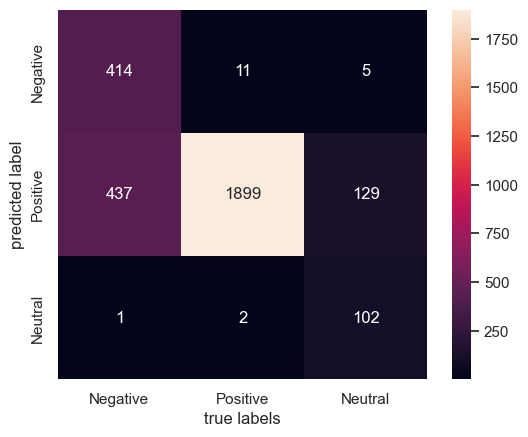

**************************************************


In [149]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model_name = "RandomForestClassifier_3_gram"

dataframe_bow = simple_logistic_classify(model, f'{model_name}_{BOW_METHOD_STRING}', X_tr_bow, y_tr, X_te_bow, y_te, BOW_METHOD_STRING)
dataframe_tfidf_transformer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_TRANSFORMER_METHOD_STRING}', X_tr_tfidf, y_tr, X_te_tfidf, y_te, TF_IDF_TRANSFORMER_METHOD_STRING)
dataframe_tfidf_vectorizer = simple_logistic_classify(model, f'{model_name}_{TF_IDF_VECTORIZER_METHOD_STRING}', X_tfidf_tr, y_tr, X_tfidf_te, y_te, TF_IDF_VECTORIZER_METHOD_STRING)

data_table_rfc_3_gram = pd.concat([dataframe_bow, dataframe_tfidf_transformer, dataframe_tfidf_vectorizer], ignore_index=True)

### Getting all dataframes together

In [150]:
data_table_3_gram = pd.concat([data_table_logistic_regression_3_gram, data_table_naive_bayes_3_gram, data_table_xgb_3_gram, data_table_svc_3_gram, data_table_rfc_3_gram], ignore_index=True)

## FINAL RESULTS:

In [151]:
final_dataframe_n_grams = pd.concat([data_table_1_gram, data_table_3_gram ], ignore_index=True)
final_dataframe_n_grams

,model,accuracy
0,LogisticRegression_1_gram_bow,0.877667
1,LogisticRegression_1_gram_tf-idf-transformer,0.883667
2,LogisticRegression_1_gram_tf-idf-vectorizer,0.854333
3,MultinomialNB_1_gram_bow,0.844333
4,MultinomialNB_1_gram_tf-idf-transformer,0.827000
5,MultinomialNB_1_gram_tf-idf-vectorizer,0.799333
6,XGBClassifier_1_gram_bow,0.870000
7,XGBClassifier_1_gram_tf-idf-transformer,0.870000
8,XGBClassifier_1_gram_tf-idf-vectorizer,0.879333
9,SVC_1_gram_bow,0.875000


# Using BERT Models

## Finetuning

### Train test split

In [31]:
#training_data, test_data = train_test_split(reduced_filtered_dataset, train_size = 0.7, random_state=42)

# Split the data into training (80%) and temporary combined (20%)

from sklearn.preprocessing import LabelEncoder

finetuning_reduced_filtered_dataset_encoded = finetuning_reduced_filtered_dataset.copy()

label_encoder = LabelEncoder()
finetuning_reduced_filtered_dataset_encoded['Label'] = label_encoder.fit_transform(finetuning_reduced_filtered_dataset['Label'])

training_data, temp_data = train_test_split(finetuning_reduced_filtered_dataset_encoded, test_size=0.2, random_state=42)

# Split the temporary combined data into validation (50%) and test (50%)
test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=42)
training_data

,Reviews,Label,CleanReviews
9272,I am not satisfied with the product. The phone...,0,satisfy product phone constantly freeze functi...
1562,Excelente Producto,2,excelente producto
1671,"Would be 5 Stars except its a T Mobile phone, ...",2,would star except mobile phone seller need cla...
6104,the phone was locked i waste the money,0,phone lock waste money
6687,The phone condition was good and it works well.,2,phone condition good work well
...,...,...,...
5751,excelente,2,excelente
5208,Good,2,good
5407,"This phone is locked, and thats really a bad w...",0,phone lock thats really bad way business displ...
860,ok,2,ok


In [32]:
# Convert Pandas DataFrame to Hugging Face Dataset format
from datasets import Dataset, DatasetDict

dataset_dict = DatasetDict({
    
    "train": Dataset.from_dict({
        "text": training_data['CleanReviews'].tolist(),
        "label": training_data['Label'].tolist(),  # Include this line if you have labels
    }),
    "test": Dataset.from_dict({
        "text": test_data['CleanReviews'].tolist(),
        "label": test_data['Label'].tolist(),  # Include this line if you have labels
    }),
    "validation": Dataset.from_dict({
        "text": validation_data['CleanReviews'].tolist(),
        "label": validation_data['Label'].tolist(),  # Include this line if you have labels
    }),
    })

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [33]:
from transformers import AutoModel
from transformers import AutoTokenizer
import torch

model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

#for inspecting the vocabulary size
print('tokenizer vocab size: ',tokenizer.vocab_size) 

#Model maximum context size
print('Model max length: ',tokenizer.model_max_length)

# features name - An attribute to know about the fields that the model expects in its forward pass:
print('Features name: ',tokenizer.model_input_names)

#result = filtered_dataset['CleanReviews'].apply(lambda x: tokenizer(x, padding=True, truncation=True))

#print(tokenize(dataset_dict['train'][:2]))



tokenizer vocab size:  30522
Model max length:  512
Features name:  ['input_ids', 'attention_mask']


In [31]:
dataset_dict['train'][:2]

{'text': ['great thank number responsibility come good', 'love'],
 'label': ['Positive', 'Positive']}

In [44]:
dataset_dict['train'].features['label'].names

['negative', 'positive', 'no_impact', 'mixed']

In [34]:
BATCHED = True
ds_pretrained_features_encoded = dataset_dict.map(tokenize, batched=BATCHED, batch_size=None)

print('Feature Names of Dataset ', ds_pretrained_features_encoded['train'].column_names)
print('Feature Names of Dataset ', ds_pretrained_features_encoded['validation'].column_names)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 7575.46 examples/s]

Feature Names of Dataset  ['text', 'label', 'input_ids', 'attention_mask']
Feature Names of Dataset  ['text', 'label', 'input_ids', 'attention_mask']


In [40]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy() }

ds_pretrained_features_encoded.set_format('torch', columns = ["input_ids", "attention_mask", "label"] )

pretrained_hidden_states = ds_pretrained_features_encoded.map(get_hidden_state, batched=BATCHED)

pretrained_hidden_states['train'].column_names

Map: 100%|██████████| 1000/1000 [03:25<00:00,  4.87 examples/s]


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [41]:
import numpy as np

X_train = np.array(pretrained_hidden_states["train"]["hidden_state"])
X_valid = np.array(pretrained_hidden_states['validation']["hidden_state"])

y_train = np.array(pretrained_hidden_states["train"]["label"])
y_valid = np.array(pretrained_hidden_states["validation"]["label"])

print(f'Xtrain_shape : {X_train.shape}')
print(f'y_train_shape : {y_train.shape}')
print(f'X_valid_shape : {X_valid.shape}')

Xtrain_shape : (8000, 768)
y_train_shape : (8000,)
X_valid_shape : (1000, 768)


In [42]:
# in this data hidden state 768 dimensions and featured scale [0,1] interval like MinMaxScale
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# initialize and fit UMAP
mapper = UMAP(n_components = 2, metric="cosine").fit(X_train_scaled)

# Create a Dataframe of 2D embeddings

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_,columns=["X","Y"])

df_embedded_from_hidden["label"] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,9.802122,5.498773,0
1,21.685490,-20.690310,2
2,11.585473,4.563148,2
3,11.083502,-3.685036,0
4,10.634808,-3.189837,2


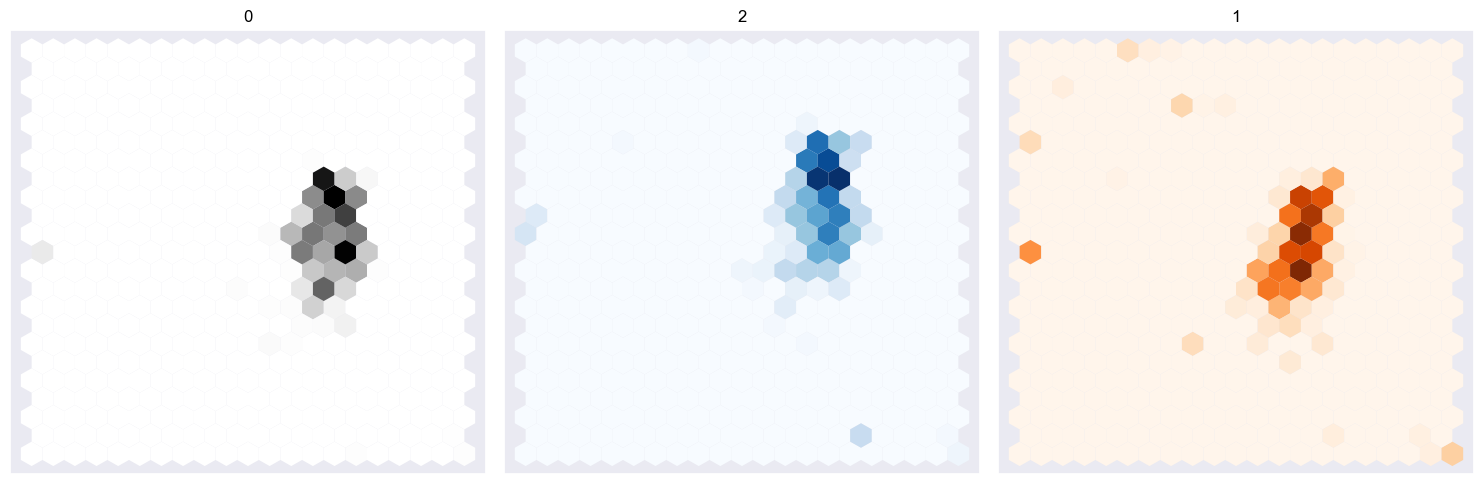

In [43]:
fig,axes = plt.subplots(1, 3, figsize=(15,5))

#1D axises
axes = axes.flatten()
''' extracting all 3 axes using flatten, so now it will be a list like below
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
'''

#Color used
cmaps = ['Greys', "Blues", "Oranges"]

#Labels name of ds_original_from_hf
#labels = dataset_dict["train"].features["label"].names
#labels = ds_original_from_hf['train'].features['label'].names

labels = df_embedded_from_hidden['label'].unique()

#separate
for i,(label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f"label == {i}")
    axes[i].hexbin(df_embedding_subplot["X"], df_embedding_subplot["Y"], cmap=cmap,
                  gridsize= 20, linewidths=(0,))
    axes[i].set_title(label, color='black')
    axes[i].set_xticks([]),axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

### Training model

In [44]:
ds_pretrained_features_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8000
})

In [45]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

num_labels = len(df_embedded_from_hidden['label'].unique())

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels ).to(device) )

from sklearn.metrics import accuracy_score, f1_score

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

batch_size = 12

logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size

model_name = f"{model_ckpt}-finetune"

training_args = TrainingArguments(output_dir = model_name, 
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error"
                                  )


trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|████▉     | 666/1334 [1:57:40<1:57:25, 10.55s/it]

{'loss': 0.5187, 'learning_rate': 1.0014992503748127e-05, 'epoch': 1.0}


 50%|█████     | 667/1334 [2:01:34<2:16:23, 12.27s/it]

{'eval_loss': 0.4227050244808197, 'eval_accuracy': 0.863, 'eval_f1': 0.8404709550184625, 'eval_runtime': 226.8737, 'eval_samples_per_second': 4.408, 'eval_steps_per_second': 0.37, 'epoch': 1.0}


100%|█████████▉| 1332/1334 [3:57:51<00:21, 10.76s/it]  

{'loss': 0.3347, 'learning_rate': 2.9985007496251873e-08, 'epoch': 2.0}


                                                     
100%|██████████| 1334/1334 [4:01:54<00:00, 10.88s/it]

{'eval_loss': 0.3970106244087219, 'eval_accuracy': 0.87, 'eval_f1': 0.8566655038609319, 'eval_runtime': 225.9291, 'eval_samples_per_second': 4.426, 'eval_steps_per_second': 0.372, 'epoch': 2.0}
{'train_runtime': 14514.2458, 'train_samples_per_second': 1.102, 'train_steps_per_second': 0.092, 'train_loss': 0.42643604299117777, 'epoch': 2.0}


TrainOutput(global_step=1334, training_loss=0.42643604299117777, metrics={'train_runtime': 14514.2458, 'train_samples_per_second': 1.102, 'train_steps_per_second': 0.092, 'train_loss': 0.42643604299117777, 'epoch': 2.0})

#### *** Traning finished after 242 minutes with 10000 rows in dataset: 8000 train data, 1000 validation data, 1000 test data

### PREDICTION: 

### Train dataset

In [46]:
preds_output = trainer.predict(ds_pretrained_features_encoded['train'])
preds_output.metrics


100%|██████████| 667/667 [47:00<00:00,  4.23s/it]


{'test_loss': 0.25791192054748535,
 'test_accuracy': 0.917125,
 'test_f1': 0.9088798954516508,
 'test_runtime': 2824.346,
 'test_samples_per_second': 2.833,
 'test_steps_per_second': 0.236}

### Validation dataset

In [47]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])
preds_output.metrics

100%|██████████| 84/84 [03:46<00:00,  2.70s/it]


{'test_loss': 0.3970106244087219,
 'test_accuracy': 0.87,
 'test_f1': 0.8566655038609319,
 'test_runtime': 229.6242,
 'test_samples_per_second': 4.355,
 'test_steps_per_second': 0.366}

### Test dataset

In [48]:
preds_output = trainer.predict(ds_pretrained_features_encoded['test'])
preds_output.metrics

100%|██████████| 84/84 [05:45<00:00,  4.11s/it]


{'test_loss': 0.43162721395492554,
 'test_accuracy': 0.861,
 'test_f1': 0.8441564765834991,
 'test_runtime': 349.7834,
 'test_samples_per_second': 2.859,
 'test_steps_per_second': 0.24}

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
    """
    This function performs a forward pass through the model, computes the loss and predicts labels.

    Args:
        batch (Dict[str, torch.Tensor]): Dictionary containing the model inputs and labels.

    Returns:
        Dict[str, Union[torch.Tensor, np.ndarray]]: Dictionary with the computed loss and predicted labels.
    """
    # Move the model inputs to the GPU (if available)
    # This is necessary because the model itself is likely on the GPU
    # Only model input names are included, other keys (e.g., 'labels') are ignored
    inputs = {k: v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names }

    # Ensures that gradients are not computed, saving memory
    with torch.no_grad():
        # Forward pass through the model
        output = model(**inputs)

        # Predict labels by selecting the argmax of the logits along the last dimension
        pred_label = torch.argmax(output.logits, axis=-1)

        # Compute the cross-entropy loss between the logits and true labels
        # reduction='none' ensures that we get a loss value for each sample, not the mean loss
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    # Returns the loss and predicted labels as numpy arrays
    # These are moved to the CPU first, because numpy cannot handle GPU tensors
    return {'loss': loss.cpu().numpy(), 
            'predicted_label': pred_label.cpu().numpy()}

#hide_output
# Convert our dataset back to PyTorch tensors
ds_pretrained_features_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_features_encoded["validation"] = ds_pretrained_features_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)

Map: 100%|██████████| 1000/1000 [03:46<00:00,  4.41 examples/s]


In [50]:
def label_int2str(row):
    return dataset_dict['train'].features['label'].int2str(row)

ds_pretrained_features_encoded.set_format("pandas")

cols = ['text', "label", "predicted_label", "loss"]

df_test = ds_pretrained_features_encoded["validation"][:][cols]

df_test["label"] = df_test["label"].apply(str)

df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(str))

df_test.sort_values('loss', ascending=False ).head(10)

,text,label,predicted_label,loss
166,good new,0,2,5.308749
590,great product great price good condition arriv...,1,2,5.292329
11,great exterior condition screen streak pink line,0,2,5.095823
342,really good device,0,2,4.992970
818,best pretty good price,1,2,4.927154
145,nice phone wish screen bigger run g everything...,1,2,4.765114
741,good price,1,2,4.729923
13,wish better easy break,0,2,4.728987
510,buy though customer please,1,2,4.703577
386,wish know get daughter bday activate without s...,2,0,4.467551


In [51]:
df_test.sort_values('loss', ascending=True ).head(10)


,text,label,predicted_label,loss
39,great ipad best ipad own excellent condition p...,2,2,0.008195
84,excellent product friendly versatile fast good...,2,2,0.008206
310,great phone reasonable price totally satisfy,2,2,0.008215
226,excellent purchase experience item describe ne...,2,2,0.008240
427,happy purchase work great,2,2,0.008250
63,great phone price issue work great fast need,2,2,0.008316
756,great price great phone,2,2,0.008436
217,great product good price,2,2,0.008446
745,great phone great condition great experience o...,2,2,0.008458
735,work perfect great price,2,2,0.008471


In [52]:
df_test.to_csv("predictions_using_pretrained_model.csv")

In [74]:
df_test = pd.read_csv("predictions_using_pretrained_model.csv", index_col=False)
df_test = df_test.iloc[:, 1:]
df_test

,text,label,predicted_label,loss
0,happier,2,2,0.030685
1,title say great little phone time could see us...,2,2,0.009463
2,work well little however phone unable send rec...,0,0,0.033192
3,love,2,2,0.012086
4,great condition refurbish new nice product,2,2,0.008547
...,...,...,...,...
995,amaze work great look brand new charger work fine,2,2,0.009307
996,please guy never buy saler disappoint buy new ...,0,2,1.121605
997,good use like,2,2,0.046118
998,phone work fine months quit capture v mail mes...,0,0,0.025859


In [77]:
y_test = df_test['label'].tolist()
y_pred = df_test['predicted_label'].tolist()

data_table_finetuned=pd.DataFrame(columns=['model', 'accuracy'])

model_ckpt = 'distilbert-base-uncased'

accuracy = accuracy_score(y_test, y_pred)

num_rows = data_table.shape[0]
model_name = model_ckpt + " finetuned/validation_dataset"
data_table_finetuned.loc[num_rows+1] = [model_name, accuracy]
data_table_finetuned

,model,accuracy
5,distilbert-base-uncased finetuned/validation_d...,0.87


## Using PRETRAINED model

In [31]:
from transformers import pipeline


e:\ELFAK\NLP\Project_Sentiment-Analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
def calculateResultsAndReturnDataframe(model_name, dataset, dataset_labels):
    y_test = dataset['Label'].tolist()
    y_pred = dataset['label_predictions'].tolist()
    # dataset_labels = dataset['Label'].unique()
   
    data_table=pd.DataFrame(columns=['model', 'accuracy'])

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {}".format(accuracy))
    print("Classification report :")
    print(classification_report(y_test, y_pred))

    mat = confusion_matrix(y_test, y_pred, labels=dataset_labels)
    sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=dataset_labels, yticklabels=dataset_labels)
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()

    num_rows = data_table.shape[0]
    data_table.loc[num_rows+1] = [model_name, accuracy]
    return data_table

### Evaluating using: nlptown/bert-base-multilingual-uncased-sentiment

Accuracy: 0.746
Classification report :
              precision    recall  f1-score   support

    Negative       0.65      0.74      0.70      2792
     Neutral       0.24      0.24      0.24       829
    Positive       0.86      0.81      0.84      6379

    accuracy                           0.75     10000
   macro avg       0.59      0.60      0.59     10000
weighted avg       0.75      0.75      0.75     10000



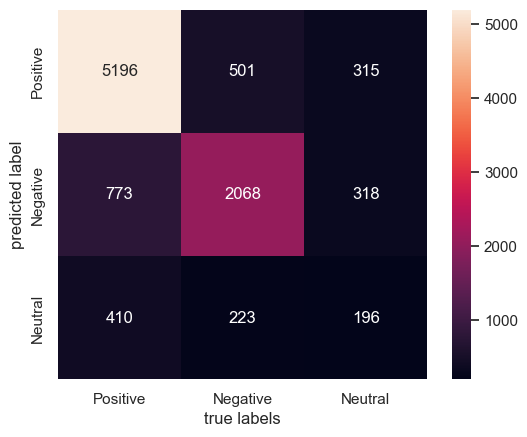

In [59]:
# sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment_pipeline = pipeline("text-classification", model=model_name)


dataset_copy = finetuning_reduced_filtered_dataset.copy()

#dataset_copy_without_neutral = dataset_copy[dataset_copy['Label'] != 'Neutral']
data = dataset_copy['CleanReviews'].tolist()

result_map = {'5 stars': 'Positive', '4 stars': 'Positive', '3 stars': 'Neutral', '2 stars': 'Negative', '1 star': 'Negative'}

results = sentiment_pipeline(data)
dataset_copy['label_predictions'] = [result_map[result['label']] for result in results]

dataframe_pretrained_1 = calculateResultsAndReturnDataframe(model_name, dataset_copy,  dataset_copy['Label'].unique())

### Evaluating using: cardiffnlp/twitter-roberta-base-sentiment

Accuracy: 0.6319
Classification report :
              precision    recall  f1-score   support

    Negative       0.83      0.38      0.52      2792
     Neutral       0.11      0.40      0.17       829
    Positive       0.87      0.77      0.82      6379

    accuracy                           0.63     10000
   macro avg       0.60      0.52      0.50     10000
weighted avg       0.79      0.63      0.68     10000



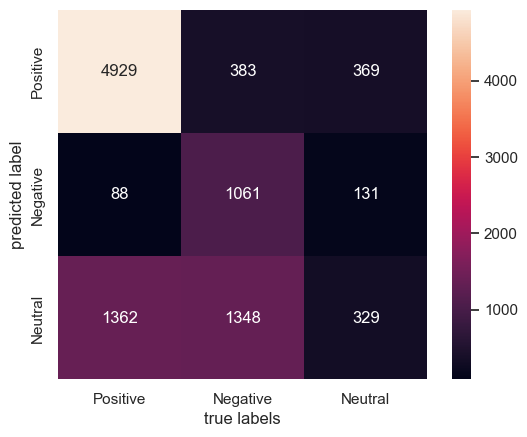

In [60]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_pipeline = pipeline("text-classification", model=model_name)

dataset_copy = finetuning_reduced_filtered_dataset.copy()

data = dataset_copy['CleanReviews'].tolist()

result_map = {'LABEL_2': 'Positive', 'LABEL_1': 'Neutral', 'LABEL_0': 'Negative'}
results = sentiment_pipeline(data)
dataset_copy['label_predictions'] = [result_map[result['label']] for result in results]


dataframe_pretrained_2 = calculateResultsAndReturnDataframe(model_name, dataset_copy,  dataset_copy['Label'].unique())

### Evaluating using: cardiffnlp/twitter-roberta-base-sentiment-latest

Accuracy: 0.6787
Classification report :
              precision    recall  f1-score   support

    Negative       0.76      0.50      0.61      2792
     Neutral       0.12      0.36      0.18       829
    Positive       0.88      0.80      0.84      6379

    accuracy                           0.68     10000
   macro avg       0.59      0.55      0.54     10000
weighted avg       0.79      0.68      0.72     10000



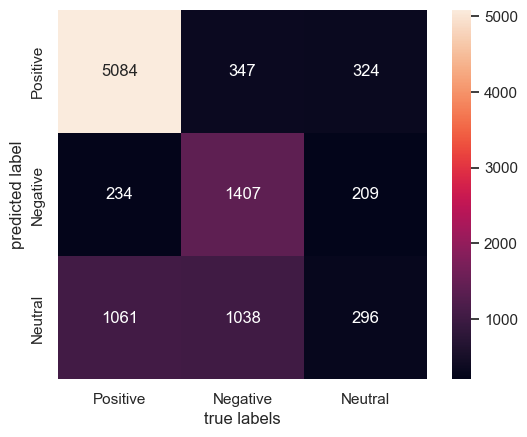

In [61]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

pipe = pipeline("text-classification", model=model_name)

dataset_copy = finetuning_reduced_filtered_dataset.copy()

#dataset_copy_without_neutral = dataset_copy[dataset_copy['Label'] != 'Neutral']
data = dataset_copy['CleanReviews'].tolist()

result_map = {'neutral': 'Neutral', 'positive': 'Positive', 'negative': 'Negative'}

results = pipe(data)

dataset_copy['label_predictions'] = [result_map[result['label']] for result in results]

dataframe_pretrained_3 = calculateResultsAndReturnDataframe(model_name, dataset_copy,  dataset_copy['Label'].unique())

### Evaluating using: distilbert-base-uncased-finetuned-sst-2-english

C:\Users\FT\AppData\Local\Temp\ipykernel_7204\2132635627.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_copy_without_neutral['label_predictions'] = [result['label'].lower().capitalize() for result in results]


Accuracy: 0.7373241740268237
Classification report :
              precision    recall  f1-score   support

    Negative       0.54      0.87      0.67      2792
    Positive       0.92      0.68      0.78      6379

    accuracy                           0.74      9171
   macro avg       0.73      0.77      0.73      9171
weighted avg       0.81      0.74      0.75      9171



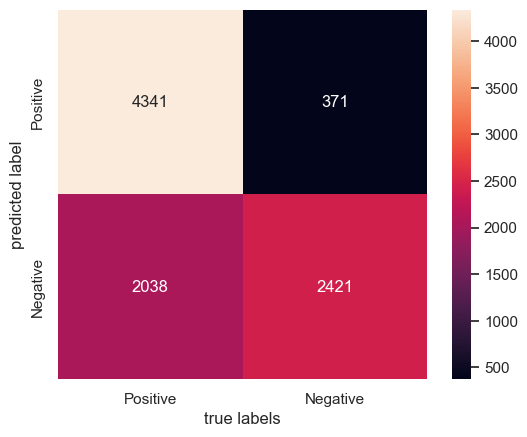

In [63]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

dataset_copy = finetuning_reduced_filtered_dataset.copy()

dataset_copy_without_neutral = dataset_copy[dataset_copy['Label'] != 'Neutral']

data = dataset_copy_without_neutral['CleanReviews'].tolist()

results = sentiment_pipeline(data)
dataset_copy_without_neutral['label_predictions'] = [result['label'].lower().capitalize() for result in results]

dataframe_pretrained_4 = calculateResultsAndReturnDataframe(model_name, dataset_copy_without_neutral,  dataset_copy_without_neutral['Label'].unique())


# FINAL ACCURACY RESULTS

## RESULTS OF N-GRAM VECTORIZATION AND CLASSIFICATION ALGORITHMS

In [152]:
final_dataframe_n_grams

,model,accuracy
0,LogisticRegression_1_gram_bow,0.877667
1,LogisticRegression_1_gram_tf-idf-transformer,0.883667
2,LogisticRegression_1_gram_tf-idf-vectorizer,0.854333
3,MultinomialNB_1_gram_bow,0.844333
4,MultinomialNB_1_gram_tf-idf-transformer,0.827000
5,MultinomialNB_1_gram_tf-idf-vectorizer,0.799333
6,XGBClassifier_1_gram_bow,0.870000
7,XGBClassifier_1_gram_tf-idf-transformer,0.870000
8,XGBClassifier_1_gram_tf-idf-vectorizer,0.879333
9,SVC_1_gram_bow,0.875000


## RESULTS OF BERT-LIKE MODELS

In [80]:
data_table = pd.concat([dataframe_pretrained_1, dataframe_pretrained_2], ignore_index=True)
data_table = pd.concat([data_table, dataframe_pretrained_3], ignore_index=True)
data_table = pd.concat([data_table, dataframe_pretrained_4], ignore_index=True)
data_table = pd.concat([data_table, data_table_finetuned], ignore_index=True)
data_table.head(15)

,model,accuracy
0,nlptown/bert-base-multilingual-uncased-sentiment,0.746000
1,cardiffnlp/twitter-roberta-base-sentiment,0.631900
2,cardiffnlp/twitter-roberta-base-sentiment-latest,0.678700
3,distilbert-base-uncased-finetuned-sst-2-english,0.737324
4,distilbert-base-uncased finetuned/validation_d...,0.870000
